In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
df_train=pd.read_csv("/content/drive/MyDrive/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/test.csv")

In [3]:
# This list will contain all the features that will be used to predict the price
features = []

In [4]:
# Calculates the mean value
def mean_value(lst):
  summed_up = sum(lst)
  mean_of_elements = summed_up / len(lst)
  return int(mean_of_elements)

In [5]:
# A function that will be used when creating new columns in the dataframe. The function checks whether a certain row equals a certain value in one of the columns, and if it does, it returns a 1.  
def check_for_label(row, label, string):
  if row[string] == label:
    return 1
  else:
    return 0

In [6]:
# A function that creates new columns, using check_for_label to fill them in appropriately

def create_column(column_string):
  unique_values = (df_train[column_string]).unique()
  unique_values_test = (df_test[column_string]).unique()

  for idx in range(len(unique_values)):
    df_train[column_string + "_" + unique_values[idx]] = df_train.apply(lambda row: check_for_label(row, unique_values[idx], column_string), axis=1)
  for idx in range(len(unique_values_test)):
    df_test[column_string + "_" + unique_values_test[idx]] = df_test.apply(lambda row: check_for_label(row, unique_values_test[idx], column_string), axis=1)

  print("Unique values for the train dataset: " + str(unique_values))
  print("Unique values for the test dataset: " + str(unique_values_test))
  for feature in unique_values:
    if feature in unique_values_test:
      features.append(column_string + "_" + feature)
      print(column_string + "_" + feature + " has been appended to the features list.")
    else:
      print("The features are inconsistent. The train dataset has the feature " + feature + ", but the test dataset does not.")
  for feature in unique_values_test:
    if feature not in unique_values:
      print("The test dataset has the feature " + feature + ", but the train dataset does not.")
  return

# Preparing Data

In [7]:
df_train.head(30)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [8]:
nan_columns = df_train.columns[df_train.isna().any()].tolist()
print(nan_columns)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
print(len(df_train.columns))
print(len(df_train))

81
1460


In [10]:
train_nans = df_train.isnull().sum().to_frame('NaN_Count')
test_nans = df_test.isnull().sum().to_frame('NaN_Count')

In [11]:
pd.set_option('display.max_rows', train_nans.shape[0]+1)
train_nans.head(81)

,NaN_Count
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
Street,0
Alley,1369
LotShape,0
LandContour,0
Utilities,0


In [12]:
pd.set_option('display.max_rows', test_nans.shape[0]+1)
test_nans.head(81)

,NaN_Count
Id,0
MSSubClass,0
MSZoning,4
LotFrontage,227
LotArea,0
Street,0
Alley,1352
LotShape,0
LandContour,0
Utilities,2


### MSZoning ###


In [13]:
#First, all unique values of the column will be found

unique_list_mszoning = []
unique_list_mszoning_test = []

for idx in range(len(df_train)):
  if df_train.iloc[idx]["MSZoning"] not in unique_list_mszoning:
    unique_list_mszoning.append(df_train.iloc[idx]["MSZoning"])
print(unique_list_mszoning)

for idx in range(len(df_test)):
  if df_test.iloc[idx]["MSZoning"] not in unique_list_mszoning_test:
    unique_list_mszoning_test.append(df_test.iloc[idx]["MSZoning"])
print(unique_list_mszoning_test)

['RL', 'RM', 'C (all)', 'FV', 'RH']
['RH', 'RL', 'RM', 'FV', 'C (all)', nan]


In [14]:
# Find the value with the highest count (including both the train and the test dataset)

rl_count = 0
rm_count = 0
c_count = 0
fv_count = 0
rh_count = 0

for idx in range(len(df_train)):
  if str(df_train.iloc[idx]["MSZoning"]) == "RL":
    rl_count += 1
  elif str(df_train.iloc[idx]["MSZoning"]) == "RM":
    rm_count += 1
  elif str(df_train.iloc[idx]["MSZoning"]) == "C (all)":
    c_count += 1
  elif str(df_train.iloc[idx]["MSZoning"]) == "FV":
    fv_count += 1
  elif str(df_train.iloc[idx]["MSZoning"]) == "RH":
    rh_count += 1

for idx in range(len(df_test)):
  if str(df_test.iloc[idx]["MSZoning"]) == "RL":
    rl_count += 1
  elif str(df_test.iloc[idx]["MSZoning"]) == "RM":
    rm_count += 1
  elif str(df_test.iloc[idx]["MSZoning"]) == "C (all)":
    c_count += 1
  elif str(df_test.iloc[idx]["MSZoning"]) == "FV":
    fv_count += 1
  elif str(df_test.iloc[idx]["MSZoning"]) == "RH":
    rh_count += 1

highest_count = {rl_count: "rl_count", rm_count: "rm_count", c_count: "c_count", fv_count: "fv_count", rh_count: "rh_count"}
highest_count.get(max(highest_count))

'rl_count'

In [15]:
# Replace all NaN values in the test dataset (there were no NaN values for the train dataset) with RL (the most common value)

df_test["MSZoning"] = df_test["MSZoning"].fillna("RL")

In [16]:
# New columns will be created. They will collectively track whether the value is RL, RM, C (all), FV, or RH - giving a 1 if their value is present, and a 0 if it is absent.

# This is done as a way to determine a value's presence without arbitrarily assigning different numbers to these values in order to distinguish them. For example, if one were only using

# the MSZoning column, it does not make sense that RL is 1 and RM is 2 etc. because their impact upon the price has not been analysed yet. 

# The "create_column" function can be found at the top of this .ipynb file.

create_column("MSZoning")

Unique values for the train dataset: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Unique values for the test dataset: ['RH' 'RL' 'RM' 'FV' 'C (all)']
MSZoning_RL has been appended to the features list.
MSZoning_RM has been appended to the features list.
MSZoning_C (all) has been appended to the features list.
MSZoning_FV has been appended to the features list.
MSZoning_RH has been appended to the features list.


In [17]:
df_train.head(31)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,0,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1,0,0,0,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,0,0,0,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1,0,0,0,0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000,1,0,0,0,0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000,1,0,0,0,0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,1,0,0,0,0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,0,1,0,0,0
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,...,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,20

### LotFrontage

In [18]:
# As there are no NaN values in LotArea, it can immediately be used to help fill in the NaN values in LotFrontage 

# The mean value for LotAreas of various sizes will be used to fill in NaN values in LotFrontage

# Gets the indices of LotAreas between certain sizes...

less_5 = []
less_10 = []
less_15 = []
less_20 = []
less_50 = []
less_100 = []
less_150 = []
more_150 = []
more_150_value = []


for idx in range(len(df_train)):
    if df_train.iloc[idx]["LotArea"] >= 0 and df_train.iloc[idx]["LotArea"] <= 5000:
      less_5.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 5000 and df_train.iloc[idx]["LotArea"] <= 10000:
      less_10.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 10000 and df_train.iloc[idx]["LotArea"] <= 15000:
      less_15.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 15000 and df_train.iloc[idx]["LotArea"] <= 20000:
      less_20.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 20000 and df_train.iloc[idx]["LotArea"] <= 50000:
      less_50.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 50000 and df_train.iloc[idx]["LotArea"] <= 100000:
      less_100.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 100000 and df_train.iloc[idx]["LotArea"] <= 150000:
      less_150.append(idx)
    elif df_train.iloc[idx]["LotArea"] >= 150000:
      more_150.append(idx)

# A function for getting LotFrontage values from the various lists of indices...

def letfrontage_values(list_of_indices):
  value_list = []
  for idx in range(len(list_of_indices)):
    value = df_train.iloc[list_of_indices[idx]]["LotFrontage"]
    value_list.append(value)
  return value_list

five_values = letfrontage_values(less_5)
ten_values = letfrontage_values(less_10)
fifteen_values = letfrontage_values(less_15)
twenty_values = letfrontage_values(less_20)
fifty_values = letfrontage_values(less_50)
hundred_values = letfrontage_values(less_100)
one_fifty_values = letfrontage_values(less_150)
more_one_fifty_values = letfrontage_values(more_150)

print(hundred_values)
print(less_100)

[68.0, nan, 62.0, nan, 47.0, 313.0, nan]
[53, 384, 451, 457, 769, 1298, 1396]


In [19]:
# Now the same thing but with the test data...

less_5 = []
less_10 = []
less_15 = []
less_20 = []
less_50 = []
less_100 = []
less_150 = []
more_150 = []
more_150_value = []

for idx in range(len(df_test)):
    if df_test.iloc[idx]["LotArea"] >= 0 and df_test.iloc[idx]["LotArea"] <= 5000:
      less_5.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 5000 and df_test.iloc[idx]["LotArea"] <= 10000:
      less_10.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 10000 and df_test.iloc[idx]["LotArea"] <= 15000:
      less_15.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 15000 and df_test.iloc[idx]["LotArea"] <= 20000:
      less_20.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 20000 and df_test.iloc[idx]["LotArea"] <= 50000:
      less_50.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 50000 and df_test.iloc[idx]["LotArea"] <= 100000:
      less_100.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 100000 and df_test.iloc[idx]["LotArea"] <= 150000:
      less_150.append(idx)
    elif df_test.iloc[idx]["LotArea"] >= 150000:
      more_150.append(idx)

def letfrontage_values_test(list_of_indices):
  value_list = []
  for idx in range(len(list_of_indices)):
    value = df_test.iloc[list_of_indices[idx]]["LotFrontage"]
    value_list.append(value)
  return value_list

five_values_test = letfrontage_values_test(less_5)
ten_values_test = letfrontage_values_test(less_10)
fifteen_values_test = letfrontage_values_test(less_15)
twenty_values_test = letfrontage_values_test(less_20)
fifty_values_test = letfrontage_values_test(less_50)
hundred_values_test = letfrontage_values_test(less_100)
one_fifty_values_test = letfrontage_values_test(less_150)
more_one_fifty_values_test = letfrontage_values_test(more_150)

print(five_values_test)
print(less_5)

[21.0, 21.0, 24.0, 24.0, 43.0, 25.0, 39.0, 30.0, 24.0, 24.0, nan, nan, 60.0, 56.0, 50.0, 52.0, nan, 67.0, 35.0, 35.0, 44.0, 31.0, 21.0, 21.0, 21.0, 21.0, 21.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 48.0, 43.0, 32.0, nan, nan, 34.0, 35.0, 68.0, 60.0, nan, 50.0, 50.0, 50.0, 42.0, 35.0, 24.0, 24.0, 24.0, 44.0, 21.0, 21.0, 21.0, 24.0, 24.0, 36.0, nan, nan, 53.0, 37.0, 30.0, 30.0, 24.0, nan, nan, 42.0, 35.0, 24.0, 24.0, 24.0, 36.0, 50.0, 80.0, 60.0, 50.0, 50.0, 63.0, nan, 24.0, 44.0, 44.0, 42.0, 32.0, nan, 41.0, 21.0, 21.0, 21.0, 38.0, 33.0, 21.0, 21.0, 24.0, 34.0, 34.0, 34.0, 48.0, nan, 53.0, 45.0, 80.0, 32.0, 40.0, 24.0, 24.0, 50.0, 51.0, 56.0, 56.0, 35.0, 60.0, 52.0, 59.0, 39.0, 35.0, 63.0, 24.0, 35.0, 46.0, 46.0, 21.0, nan, 21.0, 21.0, 30.0, 24.0, 24.0, 21.0, 21.0, 21.0, 53.0, 24.0, 24.0, 43.0, nan, nan, 43.0, 34.0, 24.0, nan, nan, 66.0, 63.0, nan, 37.0, 35.0, 24.0, 69.0, 44.0, 41.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
[11, 12, 13, 14, 23, 35, 36, 37, 38, 39, 40, 41, 70, 71, 83, 93, 124, 

In [20]:
# Join both lists and eliminate instances of "nan"...

five_values.extend(five_values_test)
five_without_nan = [x for x in five_values if str(x) != "nan"]

ten_values.extend(ten_values_test)
ten_without_nan = [x for x in ten_values if str(x) != "nan"]

fifteen_values.extend(fifteen_values_test)
fifteen_without_nan = [x for x in fifteen_values if str(x) != "nan"]

twenty_values.extend(twenty_values_test)
twenty_without_nan = [x for x in twenty_values if str(x) != "nan"]

fifty_values.extend(fifty_values_test)
fifty_without_nan = [x for x in fifty_values if str(x) != "nan"]

hundred_values.extend(hundred_values_test)
hundred_without_nan = [x for x in hundred_values if str(x) != "nan"]

one_fifty_values.extend(one_fifty_values_test)
one_fifty_without_nan = [x for x in one_fifty_values if str(x) != "nan"]

more_one_fifty_values.extend(more_one_fifty_values_test)
more_one_fifty_without_nan = [x for x in more_one_fifty_values if str(x) != "nan"]

print(fifteen_without_nan)

[68.0, 84.0, 85.0, 75.0, 70.0, 85.0, 91.0, 72.0, 66.0, 101.0, 110.0, 98.0, 85.0, 70.0, 108.0, 112.0, 48.0, 84.0, 100.0, 89.0, 66.0, 63.0, 50.0, 72.0, 95.0, 74.0, 85.0, 72.0, 60.0, 100.0, 78.0, 122.0, 80.0, 78.0, 73.0, 85.0, 94.0, 60.0, 105.0, 90.0, 88.0, 78.0, 80.0, 82.0, 70.0, 78.0, 78.0, 120.0, 107.0, 84.0, 92.0, 100.0, 110.0, 95.0, 62.0, 86.0, 80.0, 47.0, 84.0, 97.0, 63.0, 60.0, 70.0, 75.0, 99.0, 40.0, 83.0, 43.0, 72.0, 85.0, 70.0, 103.0, 75.0, 93.0, 75.0, 80.0, 75.0, 72.0, 80.0, 70.0, 78.0, 70.0, 84.0, 92.0, 107.0, 83.0, 82.0, 60.0, 75.0, 90.0, 80.0, 118.0, 80.0, 116.0, 90.0, 94.0, 99.0, 86.0, 96.0, 32.0, 80.0, 85.0, 86.0, 91.0, 66.0, 85.0, 105.0, 78.0, 59.0, 79.0, 102.0, 88.0, 96.0, 71.0, 60.0, 38.0, 60.0, 93.0, 51.0, 109.0, 85.0, 59.0, 130.0, 100.0, 43.0, 67.0, 92.0, 74.0, 85.0, 98.0, 92.0, 110.0, 75.0, 105.0, 79.0, 72.0, 79.0, 70.0, 60.0, 75.0, 55.0, 94.0, 79.0, 53.0, 60.0, 90.0, 95.0, 70.0, 67.0, 85.0, 85.0, 78.0, 87.0, 85.0, 69.0, 60.0, 77.0, 63.0, 77.0, 70.0, 79.0, 74.0, 83.0

In [21]:
# Calculates the mean value...

five_mean = mean_value(five_without_nan)

ten_mean = mean_value(ten_without_nan)

fifteen_mean = mean_value(fifteen_without_nan)

twenty_mean = mean_value(twenty_without_nan)

fifty_mean = mean_value(fifty_without_nan)

hundred_mean = mean_value(hundred_without_nan)

# one_fifty only contained a nan value, so an error will occur because its length is 0 - and you can't divide by 0
#one_fifty_mean = mean_value(one_fifty_without_nan)

more_one_fifty_mean = mean_value(more_one_fifty_without_nan)

print(ten_mean)

65


In [22]:
# Replace NaN values with the mean value...

for idx in range(len(df_train)):
    if df_train.iloc[idx]["LotArea"] >= 0 and df_train.iloc[idx]["LotArea"] <= 5000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = five_mean
    if df_train.iloc[idx]["LotArea"] >= 5000 and df_train.iloc[idx]["LotArea"] <= 10000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = ten_mean    
    if df_train.iloc[idx]["LotArea"] >= 10000 and df_train.iloc[idx]["LotArea"] <= 15000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = fifteen_mean
    if df_train.iloc[idx]["LotArea"] >= 15000 and df_train.iloc[idx]["LotArea"] <= 20000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = twenty_mean
    if df_train.iloc[idx]["LotArea"] >= 20000 and df_train.iloc[idx]["LotArea"] <= 50000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = fifty_mean
    if df_train.iloc[idx]["LotArea"] >= 50000 and df_train.iloc[idx]["LotArea"] <= 100000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = hundred_mean
    if df_train.iloc[idx]["LotArea"] >= 100000 and df_train.iloc[idx]["LotArea"] <= 150000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        # As there was just a single NaN value, the hundred_mean will be used
        df_train.loc[[idx], "LotFrontage"] = hundred_mean
    if df_train.iloc[idx]["LotArea"] >= 150000:
      if str(df_train.iloc[idx]["LotFrontage"]) == "nan":
        df_train.loc[[idx], "LotFrontage"] = more_one_fifty_mean

# Test data...

for idx in range(len(df_test)):
    if df_test.iloc[idx]["LotArea"] >= 0 and df_test.iloc[idx]["LotArea"] <= 5000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = five_mean
    if df_test.iloc[idx]["LotArea"] >= 5000 and df_test.iloc[idx]["LotArea"] <= 10000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = ten_mean 
    if df_test.iloc[idx]["LotArea"] >= 10000 and df_test.iloc[idx]["LotArea"] <= 15000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = fifteen_mean
    if df_test.iloc[idx]["LotArea"] >= 15000 and df_test.iloc[idx]["LotArea"] <= 20000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = twenty_mean
    if df_test.iloc[idx]["LotArea"] >= 20000 and df_test.iloc[idx]["LotArea"] <= 50000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = fifty_mean
    if df_test.iloc[idx]["LotArea"] >= 50000 and df_test.iloc[idx]["LotArea"] <= 100000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = hundred_mean
    if df_test.iloc[idx]["LotArea"] >= 100000 and df_test.iloc[idx]["LotArea"] <= 150000:
      # No values here
      pass
    if df_test.iloc[idx]["LotArea"] >= 150000:
      if str(df_test.iloc[idx]["LotFrontage"]) == "nan":
        df_test.loc[[idx], "LotFrontage"] = more_one_fifty_mean

      

In [23]:
# Check for NaN values in LotFrontage...

for idx in range(len(df_train)):
  if "NaN" in str(df_train["LotFrontage"].iloc[[idx]]):
    print(idx)

for idx in range(len(df_test)):
  if "NaN" in str(df_test["LotFrontage"].iloc[[idx]]):
    print(idx)


## Street


In [24]:
unique_values = (df_train["Street"]).unique()
unique_values_test = (df_test["Street"]).unique()

print(unique_values)
print(unique_values_test)

['Pave' 'Grvl']
['Pave' 'Grvl']


In [25]:
df_train["Pave_Street"] = df_train.apply(lambda row: check_for_label(row, "Pave", "Street"), axis=1)
df_train["Gravel_Street"] = df_train.apply(lambda row: check_for_label(row, "Grvl", "Street"), axis=1)

df_test["Pave_Street"] = df_test.apply(lambda row: check_for_label(row, "Pave", "Street"), axis=1)
df_test["Gravel_Street"] = df_test.apply(lambda row: check_for_label(row, "Grvl", "Street"), axis=1)

In [26]:
df_test.head(801)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,0,1,0,0,0,1,0
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,0,1,0,0,0,1,0
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,0,1,0,0,0,1,0
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2257,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,938.0,938.0,GasA,...,0.0,0.0,3,1,5,1,TA,7,Typ,1,TA,Attchd,1999.0,Fin,2.0,482.0,TA,TA,Y,188,30,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,0,1,0,0,0,1,0
797,2258,20,RL,65.0,9556,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1992,1993,Gable,CompShg,HdBoard,HdBoard,BrkFace,52.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1168.0,1168.0,GasA,...,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,1992.0,RFn,2.0,420.0,TA,TA,Y,0,21,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,0,1,0,0,0,1,0
798,2259,60,RL,65.0,7655,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,903.0,903.0,GasA,...,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2.0,392.0,TA,TA,Y,290,84,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,0,1,0,0,0,1,0
799,2260,20,RL,160.0,18160,Grvl,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,6,1964,1964,Gable,CompShg,HdBoard,HdBoard,BrkCmn,138.0,TA,

## Alley

In [27]:
# There are too many NaN values in both the train and test datasets, and there is no obvious way to fill in these values.
# Therefore, the column "alley" will be dropped.

df_train.drop(["Alley"], axis=1, inplace=True)
df_test.drop(["Alley"], axis=1, inplace=True)

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Pave_Street,Gravel_Street
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,...,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,0,0,0,0,1,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,...,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,0,0,0,0,1,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,...,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1,0,0,0,0,1,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,...,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,0,0,0,0,1,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,...,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1,0,0,0,0,1,0


## LotShape

In [28]:
create_column("LotShape")

Unique values for the train dataset: ['Reg' 'IR1' 'IR2' 'IR3']
Unique values for the test dataset: ['Reg' 'IR1' 'IR2' 'IR3']
LotShape_Reg has been appended to the features list.
LotShape_IR1 has been appended to the features list.
LotShape_IR2 has been appended to the features list.
LotShape_IR3 has been appended to the features list.


In [29]:
df_train.head(303)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,...,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,0,0,0,0,1,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,...,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,0,0,0,0,1,0,1,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,...,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1,0,0,0,0,1,0,0,1,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,...,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,0,0,0,0,1,0,0,1,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,...,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,299,60,RL,90.0,11700,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,6,1968,1968,Mansard,CompShg,HdBoard,AsphShn,BrkFace,365.0,Gd,TA,CBlock,TA,TA,No,ALQ,384,Rec,175,143,702,GasA,Gd,...,1,TA,7,Typ,1,Gd,Attchd,1968.0,Unf,2,539,TA,TA,Y,224,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,175000,1,0,0,0,0,1,0,1,0,0,0
299,300,20,RL,80.0,14000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,8,1950,2004,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,1092,1092,GasA,Ex,...,1,Gd,6,Typ,1,Gd,Attchd,1950.0,Unf,1,300,TA,TA,Y,0,36,0,0,0,0,NaN,GdPrv,NaN,0,8,2009,WD,Family,158500,1,0,0,0,0,1,0,1,0,0,0
300,301,190,RL,90.0,15750,Pave,Reg,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,2fmCon,1Story,5,5,1953,1953,Hip,CompShg,MetalSd,MetalSd,BrkFace,56.0,TA,TA,CBlock,TA,TA,Mn,BLQ,841,Unf,0,324,1165,GasA,TA,...,1,TA,5,Typ,2,Gd,Attchd,1953.0,Unf,1,375,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,157000,1,0,0,0,0,1,0,1,0,0,0
301,302,60,RL,66.0,16226,Pave,IR3,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,1998,1999,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,281,Unf,0,747,1028,GasA,Ex,...,1,Gd,9,Typ,1,TA,BuiltIn,1998.0,Fin,2,683,TA,TA,Y,208,50,0,0,0,

## LandContour


In [30]:
create_column("LandContour")

Unique values for the train dataset: ['Lvl' 'Bnk' 'Low' 'HLS']
Unique values for the test dataset: ['Lvl' 'HLS' 'Bnk' 'Low']
LandContour_Lvl has been appended to the features list.
LandContour_Bnk has been appended to the features list.
LandContour_Low has been appended to the features list.
LandContour_HLS has been appended to the features list.


In [31]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS']


## Utilities

In [32]:
# There are NaN values in the test dataset...

unique_values = (df_train["Utilities"]).unique()
unique_values_test = (df_test["Utilities"]).unique()

print(unique_values)
print(unique_values_test)

['AllPub' 'NoSeWa']
['AllPub' nan]


In [33]:
df_train["Utilities"].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [34]:
df_test["Utilities"].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

In [35]:
# Utilities can be dropped because practically every value is just "AllPub"

df_train.drop(["Utilities"], axis=1, inplace=True)
df_test.drop(["Utilities"], axis=1, inplace=True)

In [36]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0


## LotConfig



In [37]:
create_column("LotConfig")

Unique values for the train dataset: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Unique values for the test dataset: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LotConfig_Inside has been appended to the features list.
LotConfig_FR2 has been appended to the features list.
LotConfig_Corner has been appended to the features list.
LotConfig_CulDSac has been appended to the features list.
LotConfig_FR3 has been appended to the features list.


In [38]:
df_train.head(335)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,...,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,...,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,...,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,...,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,...,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,331,90,RL,80.0,10624,Pave,IR1,Lvl,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,5,4,1964,1964,Gable,CompShg,HdBoard,HdBoard,BrkFace,84.0,TA,TA,CBlock,TA,TA,No,GLQ,40,Rec,264,1424,1728,GasA,TA,Y,...,1,352,TA,TA,Y,155,0,0,0,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal,119000,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
331,332,20,RL,70.0,8176,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1958,1992,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,846,Unf,0,210,1056,GasA,Fa,Y,...,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,139000,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
332,333,20,RL,85.0,10655,Pave,IR1,Lvl,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,...,3,880,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
333,334,120,RM,59.0,8198,Pave,Reg,Lvl,FR3,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,Stone,146.0,Gd,TA,PConc,Gd,TA,Av,GLQ,720,Unf,0,638,1358,GasA,Ex,Y,...,2,484,TA,TA,Y,192,30,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,207000,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [39]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3']


## LandSlope

In [40]:
create_column("LandSlope")

Unique values for the train dataset: ['Gtl' 'Mod' 'Sev']
Unique values for the test dataset: ['Gtl' 'Mod' 'Sev']
LandSlope_Gtl has been appended to the features list.
LandSlope_Mod has been appended to the features list.
LandSlope_Sev has been appended to the features list.


In [41]:
df_test.head(71)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,...,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,...,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,...,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,...,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,...,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
5,1466,60,RL,75.0,10000,Pave,IR1,Lvl,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,...,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
6,1467,20,RL,65.0,7980,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,...,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
7,1468,60,RL,63.0,8402,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,...,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
8,1469,20,RL,85.0,10176,Pave,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,...,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
9,1470,20,RL,70.0,8400,Pave,Reg,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,804.0,Rec,78.0,0.0,882.0,GasA,TA,Y,...,TA,TA,Y,240,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [42]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev']


## Neighborhood

In [43]:
create_column("Neighborhood")

Unique values for the train dataset: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Unique values for the test dataset: ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Neighborhood_CollgCr has been appended to the features list.
Neighborhood_Veenker has been appended to the features list.
Neighborhood_Crawfor has been appended to the features list.
Neighborhood_NoRidge has been appended to the features list.
Neighborhood_Mitchel has been appended to the features list.
Neighborhood_Somerst has been appended to the features list.
Neighborhood_NWAmes has been appended to the features list.
Neighborh

In [44]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,...,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste']


## Condition1

In [46]:
create_column("Condition1")

Unique values for the train dataset: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Unique values for the test dataset: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition1_Norm has been appended to the features list.
Condition1_Feedr has been appended to the features list.
Condition1_PosN has been appended to the features list.
Condition1_Artery has been appended to the features list.
Condition1_RRAe has been appended to the features list.
Condition1_RRNn has been appended to the features list.
Condition1_RRAn has been appended to the features list.
Condition1_PosA has been appended to the features list.
Condition1_RRNe has been appended to the features list.


## Condition2

In [47]:
df_test["Condition2"].value_counts()

Norm      1444
Feedr        7
Artery       3
PosA         3
PosN         2
Name: Condition2, dtype: int64

In [48]:
df_train["Condition2"].value_counts()

Norm      1445
Feedr        6
RRNn         2
PosN         2
Artery       2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

In [49]:
# As so many values are just "Norm", Condition2 is dropped

df_train.drop(["Condition2"], axis=1, inplace=True)
df_test.drop(["Condition2"], axis=1, inplace=True)

## BldgType

In [50]:
create_column("BldgType")

Unique values for the train dataset: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Unique values for the test dataset: ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
BldgType_1Fam has been appended to the features list.
BldgType_2fmCon has been appended to the features list.
BldgType_Duplex has been appended to the features list.
BldgType_TwnhsE has been appended to the features list.
BldgType_Twnhs has been appended to the features list.


In [51]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

In [52]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


## HouseStyle

In [53]:
create_column("HouseStyle")

Unique values for the train dataset: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
Unique values for the test dataset: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']
HouseStyle_2Story has been appended to the features list.
HouseStyle_1Story has been appended to the features list.
HouseStyle_1.5Fin has been appended to the features list.
HouseStyle_1.5Unf has been appended to the features list.
HouseStyle_SFoyer has been appended to the features list.
HouseStyle_SLvl has been appended to the features list.
HouseStyle_2.5Unf has been appended to the features list.
The features are inconsistent. The train dataset has the feature 2.5Fin, but the test dataset does not.


In [54]:
df_train["HouseStyle"].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [55]:
df_test["HouseStyle"].value_counts()

1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
2.5Unf     13
1.5Unf      5
Name: HouseStyle, dtype: int64

In [56]:
# Although the test dataset does not have any "2.5Fin" values, the column will be added to keep the test dataset consistent with the train dataset

df_test["HouseStyle_2.5Fin"] = df_test.apply(lambda row: check_for_label(row, "2.5Fin", "HouseStyle"), axis=1)

In [57]:
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [58]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [59]:
# 2.5Fin gets added to features...

features.append("HouseStyle_2.5Fin")
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

## RoofStyle

In [60]:
df_test["RoofStyle"].value_counts()

Gable      1169
Hip         265
Gambrel      11
Flat          7
Mansard       4
Shed          3
Name: RoofStyle, dtype: int64

In [61]:
df_train["RoofStyle"].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [62]:
create_column("RoofStyle")

Unique values for the train dataset: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Unique values for the test dataset: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofStyle_Gable has been appended to the features list.
RoofStyle_Hip has been appended to the features list.
RoofStyle_Gambrel has been appended to the features list.
RoofStyle_Mansard has been appended to the features list.
RoofStyle_Flat has been appended to the features list.
RoofStyle_Shed has been appended to the features list.


In [63]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,...,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [64]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

## RoofMatl

In [65]:
df_test["RoofMatl"].value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

In [66]:
df_train["RoofMatl"].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64

In [67]:
# Nearly all the values are just "CompShg". This column therefore gets dropped.

df_train.drop(["RoofMatl"], axis=1, inplace=True)
df_test.drop(["RoofMatl"], axis=1, inplace=True)

## Exterior1st and Exterior2nd

In [68]:
df_test["Exterior1st"].value_counts()

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

In [69]:
df_test["Exterior2nd"].value_counts()

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
AsphShn      1
Stone        1
Name: Exterior2nd, dtype: int64

In [70]:
# There is a null value in the training dataset for Exterior1st (and Exterior2nd), so this gets replaced with the most common type of exterior...

df_test["Exterior1st"] = df_test["Exterior1st"].fillna("VinylSd")
df_test["Exterior2nd"] = df_test["Exterior2nd"].fillna("VinylSd")

In [71]:
# Exterior2nd = Exterior covering on house (if more than one material)

# This will check how many times the Exterior2nd value differs from the Exterior1st value in the same row (to determine whether Exterior2nd is worthwhile including...)

different_values = 0

for idx in range(len(df_train)):
  if df_train["Exterior1st"][idx] != df_train["Exterior2nd"][idx]:
    different_values += 1
    
print(different_values)

215


In [72]:
# Also check test dataset...

different_values_test = 0

for idx in range(len(df_test)):
  if df_test["Exterior1st"][idx] != df_test["Exterior2nd"][idx]:
    different_values_test += 1
print(different_values_test)

222


In [73]:
# Because they do differ sometimes, both columns will be included...

create_column("Exterior1st")

Unique values for the train dataset: ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Unique values for the test dataset: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' 'CBlock']
Exterior1st_VinylSd has been appended to the features list.
Exterior1st_MetalSd has been appended to the features list.
Exterior1st_Wd Sdng has been appended to the features list.
Exterior1st_HdBoard has been appended to the features list.
Exterior1st_BrkFace has been appended to the features list.
Exterior1st_WdShing has been appended to the features list.
Exterior1st_CemntBd has been appended to the features list.
Exterior1st_Plywood has been appended to the features list.
Exterior1st_AsbShng has been appended to the features list.
Exterior1st_Stucco has been appended to the features list.
Exterior1st_BrkComm has been appended to the fe

In [74]:
# Although the test dataset does not have any "Stone" and "ImStucc" values, the column will be added to keep the test dataset consistent with the train dataset

df_test["Exterior1st_Stone"] = df_test.apply(lambda row: check_for_label(row, "Stone", "Exterior1st"), axis=1)
df_test["Exterior1st_ImStucc"] = df_test.apply(lambda row: check_for_label(row, "ImStucc", "Exterior1st"), axis=1)

# these features are also added to the features list...

features.append("Exterior1st_Stone")
features.append("Exterior1st_ImStucc")

df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

In [77]:
create_column("Exterior2nd")

Unique values for the train dataset: ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
Unique values for the test dataset: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'Brk Cmn' 'CmentBd'
 'ImStucc' 'Wd Shng' 'AsbShng' 'Stucco' 'CBlock' 'BrkFace' 'AsphShn'
 'Stone']
Exterior2nd_VinylSd has been appended to the features list.
Exterior2nd_MetalSd has been appended to the features list.
Exterior2nd_Wd Shng has been appended to the features list.
Exterior2nd_HdBoard has been appended to the features list.
Exterior2nd_Plywood has been appended to the features list.
Exterior2nd_Wd Sdng has been appended to the features list.
Exterior2nd_CmentBd has been appended to the features list.
Exterior2nd_BrkFace has been appended to the features list.
Exterior2nd_Stucco has been appended to the features list.
Exterior2nd_AsbShng has been appended to the features list.
Exterior2nd_Brk Cmn 

In [78]:
df_test["Exterior2nd_Other"] = df_test.apply(lambda row: check_for_label(row, "Other", "Exterior2nd"), axis=1)
features.append("Exterior2nd_Other")

print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

In [79]:
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## MasVnrType

In [80]:
df_train["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [81]:
df_test["MasVnrType"].value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [82]:
# As it is mostly None, None will fill in the missing values...

df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_test["MasVnrType"] = df_test["MasVnrType"].fillna("None")

In [83]:
create_column("MasVnrType")

Unique values for the train dataset: ['BrkFace' 'None' 'Stone' 'BrkCmn']
Unique values for the test dataset: ['None' 'BrkFace' 'Stone' 'BrkCmn']
MasVnrType_BrkFace has been appended to the features list.
MasVnrType_None has been appended to the features list.
MasVnrType_Stone has been appended to the features list.
MasVnrType_BrkCmn has been appended to the features list.


In [84]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## MasVnrArea

In [85]:
df_train["MasVnrArea"].value_counts()

0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [86]:
df_test["MasVnrArea"].value_counts()

0.0      877
176.0     10
144.0      9
120.0      8
216.0      8
        ... 
634.0      1
177.0      1
615.0      1
549.0      1
442.0      1
Name: MasVnrArea, Length: 303, dtype: int64

In [87]:
# As a lot of the values are 0, 0 will be used to fill in the missing values...

df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)
df_test["MasVnrArea"] = df_test["MasVnrArea"].fillna(0)



In [88]:
df_test.head(235)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,Gable,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,Gable,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1691,60,RL,65.0,8174,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,494.0,Unf,0.0,204.0,698.0,GasA,Ex,Y,SBrkr,698,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
231,1692,60,RL,80.0,12891,Pave,IR1,Lvl,Corner,Gtl,Gilbert,Norm,1Fam,2Story,8,5,2002,2002,Gable,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
232,1693,80,RL,61.0,9734,Pave,IR1,Lvl,Inside,Gtl,Gilbert,RRAn,1Fam,SLvl,7,5,2004,2004,Gable,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,241.0,Rec,113.0,30.0,384.0,GasA,Ex,Y,SBrkr,744,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
233,1694,60,RL,42.0,8433,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,5,2000,2000,Gable,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,683.0,Unf,0.0,111.0,794.0,GasA,Ex,Y,SBrkr,819,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## ExterQual

In [89]:
df_train["ExterQual"].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [90]:
df_test["ExterQual"].value_counts()

TA    892
Gd    491
Ex     55
Fa     21
Name: ExterQual, dtype: int64

In [91]:
'''
Ex	= Excellent
Gd	= Good
TA	= Average/Typical
Fa	= Fair
Po	= Poor

These can be converted into numbers as excellent is of course better than good etc.
'''

df_train["ExterQual"] = df_train["ExterQual"].replace("Ex", 10)
df_train["ExterQual"] = df_train["ExterQual"].replace("Gd", 8)
df_train["ExterQual"] = df_train["ExterQual"].replace("TA", 6)
df_train["ExterQual"] = df_train["ExterQual"].replace("Fa", 4)
df_train["ExterQual"] = df_train["ExterQual"].replace("Po", 2)

df_test["ExterQual"] = df_test["ExterQual"].replace("Ex", 10)
df_test["ExterQual"] = df_test["ExterQual"].replace("Gd", 8)
df_test["ExterQual"] = df_test["ExterQual"].replace("TA", 6)
df_test["ExterQual"] = df_test["ExterQual"].replace("Fa", 4)
df_test["ExterQual"] = df_test["ExterQual"].replace("Po", 2)



In [92]:
df_test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,Gable,VinylSd,VinylSd,None,0.0,6,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,Gable,VinylSd,VinylSd,BrkFace,20.0,6,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,HdBoard,HdBoard,None,0.0,8,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1466,60,RL,75.0,10000,Pave,IR1,Lvl,Corner,Gtl,Gilbert,Norm,1Fam,2Story,6,5,1993,1994,Gable,HdBoard,HdBoard,None,0.0,6,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,1467,20,RL,65.0,7980,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,1Story,6,7,1992,2007,Gable,HdBoard,HdBoard,None,0.0,6,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,1468,60,RL,63.0,8402,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,5,1998,1998,Gable,VinylSd,VinylSd,None,0.0,6,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,1469,20,RL,85.0,10176,Pave,Reg,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,1Story,7,5,1990,1990,Gable,HdBoard,HdBoard,None,0.0,6,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,1470,20,RL,70.0,8400,Pave,Reg,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,4,5,1970,1970,Gable,Plywood,Plywood,None,0.0,6,TA,CBlock,TA,TA,No,ALQ,804.0,Rec,78.0,0.0,882.0,GasA,TA,Y,SBrkr,882,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## ExterCond

In [93]:
'''
Ex	= Excellent
Gd	= Good
TA	= Average/Typical
Fa	= Fair
Po	= Poor

These can be converted into numbers as excellent is of course better than good etc.
'''

df_train["ExterCond"] = df_train["ExterCond"].replace("Ex", 10)
df_train["ExterCond"] = df_train["ExterCond"].replace("Gd", 8)
df_train["ExterCond"] = df_train["ExterCond"].replace("TA", 6)
df_train["ExterCond"] = df_train["ExterCond"].replace("Fa", 4)
df_train["ExterCond"] = df_train["ExterCond"].replace("Po", 2)

df_test["ExterCond"] = df_test["ExterCond"].replace("Ex", 10)
df_test["ExterCond"] = df_test["ExterCond"].replace("Gd", 8)
df_test["ExterCond"] = df_test["ExterCond"].replace("TA", 6)
df_test["ExterCond"] = df_test["ExterCond"].replace("Fa", 4)
df_test["ExterCond"] = df_test["ExterCond"].replace("Po", 2)

In [94]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,6,6,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,8,6,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,6,6,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,8,6,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Foundation

In [95]:
df_train["Foundation"].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [96]:
df_test["Foundation"].value_counts()

PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: Foundation, dtype: int64

In [97]:
create_column("Foundation")

Unique values for the train dataset: ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
Unique values for the test dataset: ['CBlock' 'PConc' 'BrkTil' 'Stone' 'Slab' 'Wood']
Foundation_PConc has been appended to the features list.
Foundation_CBlock has been appended to the features list.
Foundation_BrkTil has been appended to the features list.
Foundation_Wood has been appended to the features list.
Foundation_Slab has been appended to the features list.
Foundation_Stone has been appended to the features list.


In [98]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

In [99]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,6,6,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,8,6,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,6,6,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,8,6,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## BsmtQual

In [100]:
'''

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

'''

df_train["BsmtQual"].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [101]:
# "NA" meaning 'No Basement' appears as nan values

df_train["BsmtQual"] = df_train["BsmtQual"].replace("Ex", 10)
df_train["BsmtQual"] = df_train["BsmtQual"].replace("Gd", 8)
df_train["BsmtQual"] = df_train["BsmtQual"].replace("TA", 6)
df_train["BsmtQual"] = df_train["BsmtQual"].replace("Fa", 4)
df_train["BsmtQual"] = df_train["BsmtQual"].replace("Po", 2)
df_train["BsmtQual"] = df_train["BsmtQual"].fillna(0)


df_test["BsmtQual"] = df_test["BsmtQual"].replace("Ex", 10)
df_test["BsmtQual"] = df_test["BsmtQual"].replace("Gd", 8)
df_test["BsmtQual"] = df_test["BsmtQual"].replace("TA", 6)
df_test["BsmtQual"] = df_test["BsmtQual"].replace("Fa", 4)
df_test["BsmtQual"] = df_test["BsmtQual"].replace("Po", 2)
df_test["BsmtQual"] = df_test["BsmtQual"].fillna(0)

In [102]:
df_train.head(651)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,8.0,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,6,6,CBlock,8.0,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,8,6,PConc,8.0,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,6,6,BrkTil,6.0,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,8,6,PConc,8.0,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,647,20,RL,60.0,7200,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,1Story,5,5,1950,1950,Hip,MetalSd,MetalSd,None,0.0,6,6,CBlock,0.0,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Gd,Y,SBrkr,1048,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
647,648,20,RL,85.0,10452,Pave,IR1,Lvl,Inside,Gtl,Edwards,Norm,1Fam,1Story,6,5,1953,1953,Hip,Wd Sdng,Wd Sdng,Stone,216.0,6,6,CBlock,6.0,TA,Mn,Rec,500,Unf,0,594,1094,GasA,Ex,Y,SBrkr,1094,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
648,649,60,RL,70.0,7700,Pave,Reg,Lvl,Inside,Gtl,NAmes,PosN,1Fam,2Story,6,5,1966,1966,Gable,MetalSd,MetalSd,BrkFace,351.0,6,6,CBlock,6.0,TA,No,Unf,0,Unf,0,756,756,GasA,TA,Y,SBrkr,1051,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
649,650,180,RM,21.0,1936,Pave,Reg,Lvl,Inside,Gtl,MeadowV,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CemntBd,CmentBd,None,0.0,6,6,CBlock,8.0,TA,Av,BLQ,131,GLQ,499,0,630,GasA,Gd,Y,SBrkr,630,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## BsmtCond

In [103]:
df_train["BsmtCond"] = df_train["BsmtCond"].replace("Ex", 10)
df_train["BsmtCond"] = df_train["BsmtCond"].replace("Gd", 8)
df_train["BsmtCond"] = df_train["BsmtCond"].replace("TA", 6)
df_train["BsmtCond"] = df_train["BsmtCond"].replace("Fa", 4)
df_train["BsmtCond"] = df_train["BsmtCond"].replace("Po", 2)
df_train["BsmtCond"] = df_train["BsmtCond"].fillna(0)


df_test["BsmtCond"] = df_test["BsmtCond"].replace("Ex", 10)
df_test["BsmtCond"] = df_test["BsmtCond"].replace("Gd", 8)
df_test["BsmtCond"] = df_test["BsmtCond"].replace("TA", 6)
df_test["BsmtCond"] = df_test["BsmtCond"].replace("Fa", 4)
df_test["BsmtCond"] = df_test["BsmtCond"].replace("Po", 2)
df_test["BsmtCond"] = df_test["BsmtCond"].fillna(0)

In [104]:
df_train.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,8.0,6.0,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,6,6,CBlock,8.0,6.0,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,8,6,PConc,8.0,6.0,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,6,6,BrkTil,6.0,8.0,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,8,6,PConc,8.0,6.0,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,Inside,Gtl,Mitchel,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,VinylSd,VinylSd,None,0.0,6,6,Wood,8.0,6.0,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,1Fam,1Story,8,5,2004,2005,Gable,VinylSd,VinylSd,Stone,186.0,8,6,PConc,10.0,6.0,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
7,8,60,RL,80.0,10382,Pave,IR1,Lvl,Corner,Gtl,NWAmes,PosN,1Fam,2Story,7,6,1973,1973,Gable,HdBoard,HdBoard,Stone,240.0,6,6,CBlock,8.0,6.0,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
8,9,50,RM,51.0,6120,Pave,Reg,Lvl,Inside,Gtl,OldTown,Artery,1Fam,1.5Fin,7,5,1931,1950,Gable,BrkFace,Wd Shng,None,0.0,6,6,BrkTil,6.0,6.0,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
9,10,190,RL,50.0,7420,Pave,Reg,Lvl,Corner,Gtl,BrkSide,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,MetalSd,MetalSd,None,0.0,6,6,BrkTil,6.0,6.0,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## BsmtExposure

In [105]:
'''
       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
'''

df_train["BsmtExposure"] = df_train["BsmtExposure"].replace("Gd", 8)
df_train["BsmtExposure"] = df_train["BsmtExposure"].replace("Av", 6)
df_train["BsmtExposure"] = df_train["BsmtExposure"].replace("Mn", 4)
df_train["BsmtExposure"] = df_train["BsmtExposure"].replace("No", 2)
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna(0)


df_test["BsmtExposure"] = df_test["BsmtExposure"].replace("Gd", 8)
df_test["BsmtExposure"] = df_test["BsmtExposure"].replace("Av", 6)
df_test["BsmtExposure"] = df_test["BsmtExposure"].replace("Mn", 4)
df_test["BsmtExposure"] = df_test["BsmtExposure"].replace("No", 2)
df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna(0)

## BsmtFinType1

In [106]:
'''
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
'''

df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("GLQ", 12)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("ALQ", 10)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("BLQ", 8)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("Rec", 6)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("LwQ", 4)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].replace("Unf", 2)
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna(0)

df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("GLQ", 12)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("ALQ", 10)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("BLQ", 8)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("Rec", 6)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("LwQ", 4)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].replace("Unf", 2)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].fillna(0)


## BsmtFinSF1

In [107]:
# There is a NaN value in the test dataset.

index_of_NA = df_test[df_test["BsmtFinSF1"].isnull()].index.tolist()

print(index_of_NA)

[660]


In [108]:
df_test.head(661)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,Gable,VinylSd,VinylSd,None,0.0,6,6,PConc,8.0,6.0,2.0,12.0,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,Gable,VinylSd,VinylSd,BrkFace,20.0,6,6,PConc,6.0,6.0,2.0,12.0,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,HdBoard,HdBoard,None,0.0,8,6,PConc,8.0,6.0,2.0,10.0,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,2117,50,RM,50.0,6000,Pave,Reg,Lvl,Inside,Gtl,BrkSide,Norm,1Fam,1.5Fin,6,7,1937,2000,Gable,Wd Sdng,Wd Sdng,None,0.0,6,8,BrkTil,6.0,6.0,2.0,6.0,201.0,LwQ,162.0,462.0,825.0,GasA,Ex,Y,SBrkr,825,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
657,2118,50,RM,50.0,6000,Pave,Reg,Lvl,Inside,Gtl,BrkSide,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,Wd Sdng,Wd Sdng,None,0.0,6,6,CBlock,6.0,6.0,2.0,4.0,264.0,Unf,0.0,475.0,739.0,GasA,Ex,Y,SBrkr,874,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
658,2119,45,RM,50.0,5000,Pave,Reg,Bnk,Inside,Mod,BrkSide,Norm,1Fam,1.5Unf,6,7,1926,1950,Gable,MetalSd,MetalSd,None,0.0,6,6,BrkTil,6.0,6.0,2.0,2.0,0.0,Unf,0.0,992.0,992.0,GasA,Ex,Y,SBrkr,1013,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
659,2120,50,RM,60.0,5520,Pave,IR1,Lvl,FR2,Gtl,BrkSide,Feedr,1Fam,1.5Fin,5,7,1920,1997,Gable,AsbShng,AsbShng,None,0.0,6,8,BrkTil,6.0,6.0,2.0,10.0,68.0,Unf,0.0,497.0,565.0,GasA,TA,Y,SBrkr,565,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0

In [109]:
# Because the house does not have a basement, the NaN value is replaced by 0.

df_test["BsmtFinSF1"] = df_test["BsmtFinSF1"].fillna(0)

## BsmtFinType2

In [110]:
df_train["BsmtFinType2"].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [111]:
'''
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
'''

df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("GLQ", 12)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("ALQ", 10)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("BLQ", 8)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("Rec", 6)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("LwQ", 4)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].replace("Unf", 2)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna(0)

df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("GLQ", 12)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("ALQ", 10)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("BLQ", 8)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("Rec", 6)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("LwQ", 4)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].replace("Unf", 2)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna(0)


In [112]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,8.0,6.0,2.0,12.0,706,2.0,0,150,856,GasA,Ex,Y,SBrkr,856,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,6,6,CBlock,8.0,6.0,8.0,10.0,978,2.0,0,284,1262,GasA,Ex,Y,SBrkr,1262,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,8,6,PConc,8.0,6.0,4.0,12.0,486,2.0,0,434,920,GasA,Ex,Y,SBrkr,920,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,6,6,BrkTil,6.0,8.0,2.0,10.0,216,2.0,0,540,756,GasA,Gd,Y,SBrkr,961,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,8,6,PConc,8.0,6.0,6.0,12.0,655,2.0,0,490,1145,GasA,Ex,Y,SBrkr,1145,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,Inside,Gtl,Mitchel,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,VinylSd,VinylSd,None,0.0,6,6,Wood,8.0,6.0,2.0,12.0,732,2.0,0,64,796,GasA,Ex,Y,SBrkr,796,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,1Fam,1Story,8,5,2004,2005,Gable,VinylSd,VinylSd,Stone,186.0,8,6,PConc,10.0,6.0,6.0,12.0,1369,2.0,0,317,1686,GasA,Ex,Y,SBrkr,1694,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
7,8,60,RL,80.0,10382,Pave,IR1,Lvl,Corner,Gtl,NWAmes,PosN,1Fam,2Story,7,6,1973,1973,Gable,HdBoard,HdBoard,Stone,240.0,6,6,CBlock,8.0,6.0,4.0,10.0,859,8.0,32,216,1107,GasA,Ex,Y,SBrkr,1107,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
8,9,50,RM,51.0,6120,Pave,Reg,Lvl,Inside,Gtl,OldTown,Artery,1Fam,1.5Fin,7,5,1931,1950,Gable,BrkFace,Wd Shng,None,0.0,6,6,BrkTil,6.0,6.0,2.0,2.0,0,2.0,0,952,952,GasA,Gd,Y,FuseF,1022,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
9,10,190,RL,50.0,7420,Pave,Reg,Lvl,Corner,Gtl,BrkSide,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,MetalSd,MetalSd,None,0.0,6,6,BrkTil,6.0,6.0,2.0,12.0,851,2.0,0,140,991,GasA,Ex,Y,SBrkr,1077,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## BsmtFinSF2

In [113]:
# There is a NaN value in the test dataset.

index_of_NA = df_test[df_test["BsmtFinSF2"].isnull()].index.tolist()

print(index_of_NA)

[660]


In [114]:
df_test.head(661)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,...,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,Gable,VinylSd,VinylSd,None,0.0,6,6,PConc,8.0,6.0,2.0,12.0,791.0,2.0,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,Gable,VinylSd,VinylSd,BrkFace,20.0,6,6,PConc,6.0,6.0,2.0,12.0,602.0,2.0,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,HdBoard,HdBoard,None,0.0,8,6,PConc,8.0,6.0,2.0,10.0,263.0,2.0,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,2117,50,RM,50.0,6000,Pave,Reg,Lvl,Inside,Gtl,BrkSide,Norm,1Fam,1.5Fin,6,7,1937,2000,Gable,Wd Sdng,Wd Sdng,None,0.0,6,8,BrkTil,6.0,6.0,2.0,6.0,201.0,4.0,162.0,462.0,825.0,GasA,Ex,Y,SBrkr,825,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
657,2118,50,RM,50.0,6000,Pave,Reg,Lvl,Inside,Gtl,BrkSide,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,Wd Sdng,Wd Sdng,None,0.0,6,6,CBlock,6.0,6.0,2.0,4.0,264.0,2.0,0.0,475.0,739.0,GasA,Ex,Y,SBrkr,874,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
658,2119,45,RM,50.0,5000,Pave,Reg,Bnk,Inside,Mod,BrkSide,Norm,1Fam,1.5Unf,6,7,1926,1950,Gable,MetalSd,MetalSd,None,0.0,6,6,BrkTil,6.0,6.0,2.0,2.0,0.0,2.0,0.0,992.0,992.0,GasA,Ex,Y,SBrkr,1013,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
659,2120,50,RM,60.0,5520,Pave,IR1,Lvl,FR2,Gtl,BrkSide,Feedr,1Fam,1.5Fin,5,7,1920,1997,Gable,AsbShng,AsbShng,None,0.0,6,8,BrkTil,6.0,6.0,2.0,10.0,68.0,2.0,0.0,497.0,565.0,GasA,TA,Y,SBrkr,565,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0

In [115]:
# As there is no basement, BsmtFinSF2 (Type 2 finished square feet) will be set to 0.

df_test["BsmtFinSF2"] = df_test["BsmtFinSF2"].fillna(0)

## BsmtUnfSF


In [116]:
# There is a NaN value in the test dataset.

index_of_NA = df_test[df_test["BsmtUnfSF"].isnull()].index.tolist()

print(index_of_NA)

[660]


In [117]:
# We know 660 does not have a basement, so BsmtUnfSF (Unfinished square feet of basement area) is set to 0.
df_test["BsmtUnfSF"] = df_test["BsmtUnfSF"].fillna(0)

## TotalBsmtSF

In [118]:
# There is a NaN value in the test dataset.

index_of_NA = df_test[df_test["TotalBsmtSF"].isnull()].index.tolist()

print(index_of_NA)

[660]


In [119]:
# 660 again, so NaN gets set to 0.
df_test["TotalBsmtSF"] = df_test["TotalBsmtSF"].fillna(0)

## Heating

In [120]:
df_train["Heating"].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [121]:
df_test["Heating"].value_counts()

GasA    1446
GasW       9
Grav       2
Wall       2
Name: Heating, dtype: int64

In [122]:
# Overwhelming just "GasA", so the column gets dropped...

df_train.drop(["Heating"], axis=1, inplace=True)
df_test.drop(["Heating"], axis=1, inplace=True)

## HeatingQC

In [123]:
'''
HeatingQC: Heating quality and condition
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
'''

df_train["HeatingQC"] = df_train["HeatingQC"].replace("Ex", 10)
df_train["HeatingQC"] = df_train["HeatingQC"].replace("Gd", 8)
df_train["HeatingQC"] = df_train["HeatingQC"].replace("TA", 6)
df_train["HeatingQC"] = df_train["HeatingQC"].replace("Fa", 4)
df_train["HeatingQC"] = df_train["HeatingQC"].replace("Po", 2)

df_test["HeatingQC"] = df_test["HeatingQC"].replace("Ex", 10)
df_test["HeatingQC"] = df_test["HeatingQC"].replace("Gd", 8)
df_test["HeatingQC"] = df_test["HeatingQC"].replace("TA", 6)
df_test["HeatingQC"] = df_test["HeatingQC"].replace("Fa", 4)
df_test["HeatingQC"] = df_test["HeatingQC"].replace("Po", 2)


In [124]:
df_train.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,...,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,8.0,6.0,2.0,12.0,706,2.0,0,150,856,10,Y,SBrkr,856,854,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## CentralAir

In [125]:
'''
CentralAir: Central air conditioning

       N	No
       Y	Yes
'''
df_train["CentralAir"].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [126]:
df_test["CentralAir"].value_counts()

Y    1358
N     101
Name: CentralAir, dtype: int64

In [127]:
create_column("CentralAir")

Unique values for the train dataset: ['Y' 'N']
Unique values for the test dataset: ['Y' 'N']
CentralAir_Y has been appended to the features list.
CentralAir_N has been appended to the features list.


In [128]:
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,...,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


## Electrical

In [129]:
# There is a NaN value in the test dataset. It will get replaced by the most common value.

df_train["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [130]:
df_test["Electrical"].value_counts()

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

In [131]:
df_train["Electrical"] = df_train["Electrical"].fillna("SBrkr")

In [132]:
create_column("Electrical")

Unique values for the train dataset: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
Unique values for the test dataset: ['SBrkr' 'FuseA' 'FuseF' 'FuseP']
Electrical_SBrkr has been appended to the features list.
Electrical_FuseF has been appended to the features list.
Electrical_FuseA has been appended to the features list.
Electrical_FuseP has been appended to the features list.
The features are inconsistent. The train dataset has the feature Mix, but the test dataset does not.


In [133]:
df_test["Electrical_Mix"] = df_test.apply(lambda row: check_for_label(row, "Mix", "Electrical"), axis=1)

In [134]:
features.append("Electrical_Mix")

In [135]:
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,...,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


## BsmtFullBath

In [136]:
# There are two NaN values in the test dataset... these will get replaced by the most common value.

df_train["BsmtFullBath"].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [137]:
df_test["BsmtFullBath"].value_counts()

0.0    849
1.0    584
2.0     23
3.0      1
Name: BsmtFullBath, dtype: int64

In [138]:
df_test["BsmtFullBath"] = df_test["BsmtFullBath"].fillna("0")

## BsmtHalfBath

In [139]:
# There are two NaN values in the test dataset... these will get replaced by the most common value.

df_train["BsmtHalfBath"].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [140]:
df_test["BsmtFullBath"].value_counts()

0.0    849
1.0    584
2.0     23
0        2
3.0      1
Name: BsmtFullBath, dtype: int64

In [141]:
df_test["BsmtHalfBath"] = df_test["BsmtHalfBath"].fillna("0")

## KitchenQual

In [142]:
# There is a NaN value in the test dataset...
df_train["KitchenQual"].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [143]:
df_test["KitchenQual"].value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [144]:
df_test["KitchenQual"] = df_test["KitchenQual"].fillna("TA")

In [145]:
df_train["KitchenQual"] = df_train["KitchenQual"].replace("Ex", 10)
df_train["KitchenQual"] = df_train["KitchenQual"].replace("Gd", 8)
df_train["KitchenQual"] = df_train["KitchenQual"].replace("TA", 6)
df_train["KitchenQual"] = df_train["KitchenQual"].replace("Fa", 4)

df_test["KitchenQual"] = df_test["KitchenQual"].replace("Ex", 10)
df_test["KitchenQual"] = df_test["KitchenQual"].replace("Gd", 8)
df_test["KitchenQual"] = df_test["KitchenQual"].replace("TA", 6)
df_test["KitchenQual"] = df_test["KitchenQual"].replace("Fa", 4)

In [146]:
pd.set_option('display.max_columns', 500)
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


## Functional

In [147]:
# There are two NaN values in the test dataset... 

df_train["Functional"].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [148]:
df_test["Functional"].value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [149]:
df_test["Functional"] = df_test["Functional"].fillna("Typ")

In [150]:
'''
Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
'''
df_train["Functional"] = df_train["Functional"].replace("Typ", 12)
df_train["Functional"] = df_train["Functional"].replace("Min1", 10)
df_train["Functional"] = df_train["Functional"].replace("Min2", 8)
df_train["Functional"] = df_train["Functional"].replace("Mod", 6)
df_train["Functional"] = df_train["Functional"].replace("Maj1", 4)
df_train["Functional"] = df_train["Functional"].replace("Maj2", 2)
df_train["Functional"] = df_train["Functional"].replace("Sev", 0)

df_test["Functional"] = df_test["Functional"].replace("Typ", 12)
df_test["Functional"] = df_test["Functional"].replace("Min1", 10)
df_test["Functional"] = df_test["Functional"].replace("Min2", 8)
df_test["Functional"] = df_test["Functional"].replace("Mod", 6)
df_test["Functional"] = df_test["Functional"].replace("Maj1", 4)
df_test["Functional"] = df_test["Functional"].replace("Maj2", 2)
df_test["Functional"] = df_test["Functional"].replace("Sev", 0)

In [151]:
df_test.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0


## FireplaceQu

In [152]:
'''
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
'''

df_train["FireplaceQu"] = df_train["FireplaceQu"].replace("Ex", 10)
df_train["FireplaceQu"] = df_train["FireplaceQu"].replace("Gd", 8)
df_train["FireplaceQu"] = df_train["FireplaceQu"].replace("TA", 6)
df_train["FireplaceQu"] = df_train["FireplaceQu"].replace("Fa", 4)
df_train["FireplaceQu"] = df_train["FireplaceQu"].replace("Po", 2)
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna(0)

df_test["FireplaceQu"] = df_test["FireplaceQu"].replace("Ex", 10)
df_test["FireplaceQu"] = df_test["FireplaceQu"].replace("Gd", 8)
df_test["FireplaceQu"] = df_test["FireplaceQu"].replace("TA", 6)
df_test["FireplaceQu"] = df_test["FireplaceQu"].replace("Fa", 4)
df_test["FireplaceQu"] = df_test["FireplaceQu"].replace("Po", 2)
df_test["FireplaceQu"] = df_test["FireplaceQu"].fillna(0)

## GarageType

In [153]:
'''
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
'''
df_train["GarageType"] = df_train["GarageType"].fillna("NoGarage")
df_test["GarageType"] = df_test["GarageType"].fillna("NoGarage")

In [154]:
create_column("GarageType")

Unique values for the train dataset: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'NoGarage' 'Basment' '2Types']
Unique values for the test dataset: ['Attchd' 'Detchd' 'BuiltIn' 'NoGarage' 'Basment' '2Types' 'CarPort']
GarageType_Attchd has been appended to the features list.
GarageType_Detchd has been appended to the features list.
GarageType_BuiltIn has been appended to the features list.
GarageType_CarPort has been appended to the features list.
GarageType_NoGarage has been appended to the features list.
GarageType_Basment has been appended to the features list.
GarageType_2Types has been appended to the features list.


## GarageYrBlt

In [155]:
for idx in range(len(df_train)):
    if df_train.iloc[idx]["GarageType_NoGarage"] == 1:
      df_train.loc[[idx], "GarageYrBlt"] = 0
for idx in range(len(df_test)):
    if df_test.iloc[idx]["GarageType_NoGarage"] == 1:
      df_test.loc[[idx], "GarageYrBlt"] = 0

# There are two NA values in the test dataset...

index_of_NA = df_test[df_test["GarageYrBlt"].isnull()].index.tolist()

print(index_of_NA)

[666, 1116]


In [156]:
df_test.head(667)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,GarageType_CarPort
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,6,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,0.0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,

In [157]:
first_list = df_train["GarageYrBlt"].tolist()
second_list = df_test["GarageYrBlt"].tolist()
first_list.extend(second_list)
first_list_without_nan = [x for x in first_list if str(x) != "nan"]

In [158]:
print(first_list_without_nan)
print(len(first_list_without_nan))

[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993.0, 2004.0, 1973.0, 1931.0, 1939.0, 1965.0, 2005.0, 1962.0, 2006.0, 1960.0, 1991.0, 1970.0, 1967.0, 2004.0, 1958.0, 2005.0, 1930.0, 2002.0, 1976.0, 1968.0, 2007.0, 2005.0, 2008.0, 1957.0, 1920.0, 1920.0, 1966.0, 2007.0, 1959.0, 2005.0, 2004.0, 1995.0, 1954.0, 1953.0, 0.0, 1965.0, 1959.0, 1983.0, 1977.0, 1959.0, 2005.0, 2003.0, 2006.0, 0.0, 1966.0, 1997.0, 1985.0, 1963.0, 1981.0, 1962.0, 1964.0, 1999.0, 2004.0, 2006.0, 1973.0, 2006.0, 1935.0, 2006.0, 1990.0, 1998.0, 2004.0, 1970.0, 2003.0, 1945.0, 1953.0, 1973.0, 1987.0, 1998.0, 1989.0, 1915.0, 1973.0, 1956.0, 1948.0, 0.0, 1966.0, 1968.0, 1998.0, 2007.0, 1974.0, 1995.0, 1991.0, 2005.0, 2009.0, 0.0, 0.0, 1950.0, 1961.0, 1921.0, 1900.0, 1997.0, 1993.0, 1999.0, 1965.0, 1920.0, 0.0, 1977.0, 1985.0, 1979.0, 2009.0, 1951.0, 2003.0, 1954.0, 1948.0, 0.0, 1977.0, 1954.0, 2000.0, 2007.0, 1953.0, 1945.0, 1999.0, 1962.0, 2007.0, 1990.0, 2005.0, 1969.0, 1979.0, 1958.0, 1993.0, 1979.0, 0.0, 1977.0, 0.0, 19

In [159]:
# We know there is a garage for these rows, so taking 0 into account when calculating the mean does not make sense...
first_list_without_0 = [x for x in first_list_without_nan if x != 0]
print(len(first_list_without_0))

2760


In [160]:
the_mean = mean_value(first_list_without_0)
print(the_mean)

1978


In [161]:
df_test["GarageYrBlt"] = df_test["GarageYrBlt"].fillna(1978)

## GarageFinish

In [162]:
'''
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
'''

for idx in range(len(df_train)):
    if df_train.iloc[idx]["GarageType_NoGarage"] == 1:
      df_train.loc[[idx], "GarageFinish"] = 0
for idx in range(len(df_test)):
    if df_test.iloc[idx]["GarageType_NoGarage"] == 1:
      df_test.loc[[idx], "GarageFinish"] = 0



In [163]:
# There are still two NA values in the test dataset...

index_of_NA = df_test[df_test["GarageFinish"].isnull()].index.tolist()

print(index_of_NA)

[666, 1116]


In [164]:
df_test.head(667)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,GarageType_CarPort
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,6,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,0.0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,

In [165]:
df_test.head(1117)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,GarageType_CarPort
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,6,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,0.0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,

In [166]:
# As the values for the quality and the condition of these garages are also missing, the NaN values will be replaced by the mode...

df_train["GarageFinish"].value_counts()

Unf    605
RFn    422
Fin    352
0       81
Name: GarageFinish, dtype: int64

In [167]:
df_test["GarageFinish"].value_counts()

Unf    625
RFn    389
Fin    367
0       76
Name: GarageFinish, dtype: int64

In [168]:
df_test["GarageFinish"] = df_test["GarageFinish"].fillna("Unf")

In [169]:
df_train["GarageFinish"] = df_train["GarageFinish"].replace("Fin", 6)
df_train["GarageFinish"] = df_train["GarageFinish"].replace("RFn", 4)
df_train["GarageFinish"] = df_train["GarageFinish"].replace("Unf", 2)

df_test["GarageFinish"] = df_test["GarageFinish"].replace("Fin", 6)
df_test["GarageFinish"] = df_test["GarageFinish"].replace("RFn", 4)
df_test["GarageFinish"] = df_test["GarageFinish"].replace("Unf", 2)

In [170]:
df_test["GarageFinish"].value_counts()

2    627
4    389
6    367
0     76
Name: GarageFinish, dtype: int64

## GarageCars

In [171]:
# There is one NaN value in the test dataset.

df_train["GarageCars"].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [172]:
df_test["GarageCars"].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

In [173]:
index_of_NA = df_test[df_test["GarageCars"].isnull()].index.tolist()

print(index_of_NA)

[1116]


In [174]:
df_test.head(1117)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,GarageType_CarPort
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,Attchd,1961.0,2,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,6,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,0.0,Attchd,1958.0,2,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Norm

In [175]:
df_test["GarageCars"] = df_test["GarageCars"].fillna(2)

## GarageArea

In [176]:
# There is a NaN value in the test dataset.

index_of_NA = df_test[df_test["GarageArea"].isnull()].index.tolist()

print(index_of_NA)

[1116]


In [177]:
first_list = df_train["GarageArea"].tolist()
print(first_list)

[548, 460, 608, 642, 836, 480, 636, 484, 468, 205, 384, 736, 352, 840, 352, 576, 480, 516, 576, 294, 853, 280, 534, 572, 270, 890, 576, 772, 319, 240, 250, 271, 484, 447, 556, 691, 672, 498, 246, 0, 440, 308, 504, 308, 300, 576, 670, 826, 0, 386, 388, 528, 516, 894, 572, 576, 480, 565, 641, 352, 576, 288, 484, 480, 645, 852, 576, 558, 220, 667, 516, 360, 427, 490, 379, 297, 283, 240, 0, 440, 509, 405, 758, 461, 400, 462, 400, 528, 0, 0, 420, 480, 432, 506, 684, 420, 472, 432, 366, 0, 480, 476, 410, 740, 240, 648, 273, 250, 0, 546, 325, 400, 792, 450, 180, 440, 288, 430, 594, 390, 540, 264, 288, 530, 435, 0, 440, 0, 453, 750, 487, 390, 624, 471, 440, 530, 318, 766, 660, 470, 0, 660, 720, 577, 504, 380, 180, 434, 0, 240, 440, 866, 495, 564, 312, 0, 625, 680, 678, 576, 516, 726, 532, 0, 216, 0, 303, 789, 440, 511, 660, 528, 504, 504, 616, 576, 521, 451, 1166, 480, 440, 216, 252, 484, 576, 840, 497, 180, 528, 682, 440, 484, 666, 380, 352, 440, 786, 795, 0, 856, 440, 473, 398, 420, 240, 500

In [178]:
second_list = df_test["GarageArea"].tolist()
print(second_list)

[730.0, 312.0, 482.0, 470.0, 506.0, 440.0, 420.0, 393.0, 506.0, 525.0, 511.0, 264.0, 320.0, 440.0, 308.0, 751.0, 868.0, 730.0, 678.0, 958.0, 756.0, 484.0, 430.0, 437.0, 400.0, 433.0, 962.0, 880.0, 676.0, 528.0, 484.0, 429.0, 461.0, 762.0, 713.0, 506.0, 588.0, 480.0, 480.0, 480.0, 440.0, 496.0, 852.0, 592.0, 596.0, 535.0, 660.0, 678.0, 441.0, 490.0, 504.0, 517.0, 480.0, 0.0, 400.0, 470.0, 315.0, 576.0, 620.0, 308.0, 312.0, 440.0, 263.0, 318.0, 305.0, 264.0, 676.0, 280.0, 484.0, 440.0, 240.0, 0.0, 551.0, 240.0, 240.0, 315.0, 780.0, 288.0, 624.0, 0.0, 624.0, 363.0, 315.0, 200.0, 240.0, 576.0, 240.0, 312.0, 624.0, 480.0, 288.0, 572.0, 0.0, 180.0, 365.0, 180.0, 0.0, 231.0, 0.0, 450.0, 0.0, 416.0, 280.0, 591.0, 480.0, 690.0, 440.0, 522.0, 480.0, 467.0, 209.0, 366.0, 572.0, 504.0, 528.0, 1017.0, 615.0, 484.0, 580.0, 513.0, 308.0, 484.0, 850.0, 621.0, 420.0, 240.0, 319.0, 336.0, 480.0, 352.0, 0.0, 260.0, 399.0, 0.0, 0.0, 312.0, 484.0, 473.0, 598.0, 531.0, 200.0, 625.0, 330.0, 525.0, 741.0, 473

In [179]:
first_list.extend(second_list)
print(len(first_list))

2919


In [180]:
first_list_without_nan = [x for x in first_list if str(x) != "nan"]
print(len(first_list_without_nan))

2918


In [181]:
the_mean = mean_value(first_list_without_nan)
print(the_mean)

472


In [182]:
df_test["GarageArea"] = df_test["GarageArea"].fillna(472)

## GarageQual

In [183]:
'''
GarageQual: Garage quality
       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
'''
for idx in range(len(df_train)):
    if df_train.iloc[idx]["GarageType_NoGarage"] == 1:
      df_train.loc[[idx], "GarageQual"] = 0
for idx in range(len(df_test)):
    if df_test.iloc[idx]["GarageType_NoGarage"] == 1:
      df_test.loc[[idx], "GarageQual"] = 0

In [184]:
# There are still two NA values in the test dataset...

index_of_NA = df_test[df_test["GarageQual"].isnull()].index.tolist()

print(index_of_NA)

[666, 1116]


In [185]:
df_test.head(1117)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_FV,MSZoning_C (all),Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_HLS,LandContour_Bnk,LandContour_Low,LotConfig_Inside,LotConfig_Corner,LotConfig_FR2,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_SWISU,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRNe,Condition1_Artery,Condition1_RRNn,Condition1_PosA,Condition1_RRAn,Condition1_RRAe,BldgType_1Fam,BldgType_TwnhsE,BldgType_Twnhs,BldgType_Duplex,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_SFoyer,HouseStyle_2.5Unf,HouseStyle_1.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Flat,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_MetalSd,Exterior1st_CemntBd,Exterior1st_WdShing,Exterior1st_BrkFace,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_MetalSd,Exterior2nd_Brk Cmn,Exterior2nd_CmentBd,Exterior2nd_ImStucc,Exterior2nd_Wd Shng,Exterior2nd_AsbShng,Exterior2nd_Stucco,Exterior2nd_CBlock,Exterior2nd_BrkFace,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,MasVnrType_None,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_CBlock,Foundation_PConc,Foundation_BrkTil,Foundation_Stone,Foundation_Slab,Foundation_Wood,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,GarageType_CarPort
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,Gable,VinylSd,VinylSd,None,0.0,6,6,CBlock,6.0,6.0,2.0,6.0,468.0,4.0,144.0,270.0,882.0,6,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,Attchd,1961.0,2,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Hip,Wd Sdng,Wd Sdng,BrkFace,108.0,6,6,CBlock,6.0,6.0,2.0,10.0,923.0,2.0,0.0,406.0,1329.0,6,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,0.0,Attchd,1958.0,2,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Norm

In [186]:
df_train["GarageQual"].value_counts()

TA    1311
0       81
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [187]:
df_test["GarageQual"].value_counts()

TA    1293
Fa      76
0       76
Gd      10
Po       2
Name: GarageQual, dtype: int64

In [188]:
df_test["GarageQual"] = df_test["GarageQual"].fillna("TA")

In [189]:
df_train["GarageQual"] = df_train["GarageQual"].replace("Ex", 10)
df_train["GarageQual"] = df_train["GarageQual"].replace("Gd", 8)
df_train["GarageQual"] = df_train["GarageQual"].replace("TA", 6)
df_train["GarageQual"] = df_train["GarageQual"].replace("Fa", 4)
df_train["GarageQual"] = df_train["GarageQual"].replace("Po", 2)

df_test["GarageQual"] = df_test["GarageQual"].replace("Ex", 10)
df_test["GarageQual"] = df_test["GarageQual"].replace("Gd", 8)
df_test["GarageQual"] = df_test["GarageQual"].replace("TA", 6)
df_test["GarageQual"] = df_test["GarageQual"].replace("Fa", 4)
df_test["GarageQual"] = df_test["GarageQual"].replace("Po", 2)

## GarageCond

In [190]:
'''
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
'''
for idx in range(len(df_train)):
    if df_train.iloc[idx]["GarageType_NoGarage"] == 1:
      df_train.loc[[idx], "GarageCond"] = 0
for idx in range(len(df_test)):
    if df_test.iloc[idx]["GarageType_NoGarage"] == 1:
      df_test.loc[[idx], "GarageCond"] = 0

In [191]:
# Two NaN values in test dataset again
index_of_NA = df_test[df_test["GarageCond"].isnull()].index.tolist()

print(index_of_NA)

[666, 1116]


In [192]:
df_train["GarageCond"].value_counts()

TA    1326
0       81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [193]:
df_train["GarageCond"].value_counts()

TA    1326
0       81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [194]:
df_test["GarageCond"] = df_test["GarageCond"].fillna("TA")

In [195]:
df_train["GarageCond"] = df_train["GarageCond"].replace("Ex", 10)
df_train["GarageCond"] = df_train["GarageCond"].replace("Gd", 8)
df_train["GarageCond"] = df_train["GarageCond"].replace("TA", 6)
df_train["GarageCond"] = df_train["GarageCond"].replace("Fa", 4)
df_train["GarageCond"] = df_train["GarageCond"].replace("Po", 2)

df_test["GarageCond"] = df_test["GarageCond"].replace("Ex", 10)
df_test["GarageCond"] = df_test["GarageCond"].replace("Gd", 8)
df_test["GarageCond"] = df_test["GarageCond"].replace("TA", 6)
df_test["GarageCond"] = df_test["GarageCond"].replace("Fa", 4)
df_test["GarageCond"] = df_test["GarageCond"].replace("Po", 2)

## PavedDrive

In [196]:
create_column("PavedDrive")

Unique values for the train dataset: ['Y' 'N' 'P']
Unique values for the test dataset: ['Y' 'N' 'P']
PavedDrive_Y has been appended to the features list.
PavedDrive_N has been appended to the features list.
PavedDrive_P has been appended to the features list.


## PoolQC, Fence, and MiscFeature



In [197]:
# There are so many NaN values that these columns just get dropped.

df_train.drop(["PoolQC"], axis=1, inplace=True)
df_test.drop(["PoolQC"], axis=1, inplace=True)

df_train.drop(["Fence"], axis=1, inplace=True)
df_test.drop(["Fence"], axis=1, inplace=True)

df_train.drop(["MiscFeature"], axis=1, inplace=True)
df_test.drop(["MiscFeature"], axis=1, inplace=True)

## SaleType

In [198]:
# There is one NaN value in the test dataset...

df_train["SaleType"].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [199]:
df_test["SaleType"].value_counts()

WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
Con         3
ConLw       3
Name: SaleType, dtype: int64

In [200]:
df_test["SaleType"] = df_test["SaleType"].fillna("WD")

In [201]:
create_column("SaleType")

Unique values for the train dataset: ['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
Unique values for the test dataset: ['WD' 'COD' 'New' 'ConLD' 'Oth' 'Con' 'ConLw' 'ConLI' 'CWD']
SaleType_WD has been appended to the features list.
SaleType_New has been appended to the features list.
SaleType_COD has been appended to the features list.
SaleType_ConLD has been appended to the features list.
SaleType_ConLI has been appended to the features list.
SaleType_CWD has been appended to the features list.
SaleType_ConLw has been appended to the features list.
SaleType_Con has been appended to the features list.
SaleType_Oth has been appended to the features list.


## SaleCondition

In [202]:
create_column("SaleCondition")

Unique values for the train dataset: ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
Unique values for the test dataset: ['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']
SaleCondition_Normal has been appended to the features list.
SaleCondition_Abnorml has been appended to the features list.
SaleCondition_Partial has been appended to the features list.
SaleCondition_AdjLand has been appended to the features list.
SaleCondition_Alloca has been appended to the features list.
SaleCondition_Family has been appended to the features list.


# Evaluation, Training and Prediction

## Sorting train and test data for evaluation, training and prediction

In [203]:
print(features)

['MSZoning_RL', 'MSZoning_RM', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_Reg', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Lvl', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_CollgCr', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Edwards', 'Neighborhood_Timber', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_Norm', 'Condition1_Feedr', 'Co

In [204]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,Pave_Street,Gravel_Street,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_Stone,Exterior1st_ImStucc,Exterior1st_CBlock,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_Other,Exterior2nd_CBlock,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,8,6,PConc,8.0,6.0,2.0,12.0,706,2.0,0,150,856,10,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,8,8,12,0,0.0,Attchd,2003.0,4,2,548,6,6,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,20,RL,80.0

In [205]:
features.append("MSSubClass")
features.append("LotFrontage")
features.append("LotArea")
features.append("OverallQual")
features.append("OverallCond")
features.append("YearBuilt")
features.append("YearRemodAdd")
features.append("MasVnrArea")
features.append("ExterQual")
features.append("ExterCond")
features.append("BsmtQual")
features.append("BsmtCond")
features.append("BsmtExposure")
features.append("BsmtFinType1")
features.append("BsmtFinSF1")
features.append("BsmtFinSF2")
features.append("BsmtUnfSF")
features.append("TotalBsmtSF")
features.append("HeatingQC")
features.append("1stFlrSF")
features.append("2ndFlrSF")
features.append("LowQualFinSF")
features.append("GrLivArea")
features.append("BsmtFullBath")
features.append("BsmtHalfBath")
features.append("FullBath")
features.append("HalfBath")
features.append("BedroomAbvGr")
features.append("KitchenAbvGr")
features.append("KitchenQual")
features.append("TotRmsAbvGrd")
features.append("Functional")
features.append("Fireplaces")
features.append("FireplaceQu")
features.append("GarageYrBlt")
features.append("GarageFinish")
features.append("GarageCars")
features.append("GarageArea")
features.append("GarageQual")
features.append("GarageCond")
features.append("WoodDeckSF")
features.append("OpenPorchSF")
features.append("EnclosedPorch")
features.append("3SsnPorch")
features.append("ScreenPorch")
features.append("PoolArea")
features.append("MiscVal")
features.append("MoSold")
features.append("YrSold")

In [206]:
scale_features = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MasVnrArea", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "HeatingQC", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional", "Fireplaces", "FireplaceQu", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold"]

In [207]:
train_data_x = df_train[features]
train_data_x.head(10)

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,60,65.0,8450,7,5,2003,2003,196.0,8,6,8.0,6.0,2.0,12.0,706,0,150,856,10,856,854,0,1710,1,0,2,1,3,1,8,8,12,0,0.0,2003.0,4,2,548,6,6,0,61,0,0,0,0,0,2,2008
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,80.0,9600,6,8,1976,1976,0.0,6,6,8.0,6.0,8.0,10.0,978,0,284,1262,10,1262,0,0,1262,0,1,2,0,3,1,6,6,12,1,6.0,1976.0,4,2,460,6,

In [208]:
print(len(train_data_x.columns))

196


In [209]:
train_data_y = df_train[["SalePrice"]]
train_data_y.head(10)

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


In [210]:
test_data_x = df_test[features]
test_data_x.head(5)

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,80.0,11622,5,6,1961,1961,0.0,6,6,6.0,6.0,2.0,6.0,468.0,144.0,270.0,882.0,6,896,0,0,896,0,0,1,0,2,1,6,5,12,0,0.0,1961.0,2,1.0,730.0,6,6,140,0,0,0,120,0,0,6,2010
1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,81.0,14267,6,6,1958,1958,108.0,6,6,6.0,6.0,2.0,10.0,923.0,0.0,406.0,1329.0,6,1329,0,0,1329,0,0,1,1,3,1,8,6,12,0,

In [211]:
all_the_data = pd.concat([train_data_x, test_data_x])

In [212]:
all_the_data.head()

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,60,65.0,8450,7,5,2003,2003,196.0,8,6,8.0,6.0,2.0,12.0,706.0,0.0,150.0,856.0,10,856,854,0,1710,1,0,2,1,3,1,8,8,12,0,0.0,2003.0,4,2.0,548.0,6,6,0,61,0,0,0,0,0,2,2008
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,80.0,9600,6,8,1976,1976,0.0,6,6,8.0,6.0,8.0,10.0,978.0,0.0,284.0,1262.0,10,1262,0,0,1262,0,1,2,0,3,1,6,6,12,1,6

In [213]:
print(len(all_the_data))

2919


In [214]:
scaled_features = all_the_data.copy()

In [215]:
col_names = scale_features

In [216]:
featuress = scaled_features[col_names]
scaler = StandardScaler().fit(featuress.values)
featuress = scaler.transform(featuress.values)
scaled_features[col_names] = featuress

In [217]:
scaled_features.head(5)

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.067331,-0.222137,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,1.039805,-0.230047,0.577094,0.141836,-0.583117,1.163184,0.581145,-0.293025,-0.934165,-0.443078,0.885619,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,0.986849,0.237316,-0.924311,-0.978830,0.293730,0.316115,0.306418,0.348901,0.276668,0.266878,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,0.157646
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1

In [218]:
train_after_split = scaled_features.iloc[:1460]
test_after_split = scaled_features.iloc[1460:]

In [219]:
print(len(train_after_split))
print(len(test_after_split))

1460
1459


In [220]:
train_after_split.head(5)

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.067331,-0.222137,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,1.039805,-0.230047,0.577094,0.141836,-0.583117,1.163184,0.581145,-0.293025,-0.934165,-0.443078,0.885619,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,0.986849,0.237316,-0.924311,-0.978830,0.293730,0.316115,0.306418,0.348901,0.276668,0.266878,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,0.157646
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1

In [221]:
test_after_split.head(5)

,MSZoning_RL,MSZoning_RM,MSZoning_C (all),MSZoning_FV,MSZoning_RH,LotShape_Reg,LotShape_IR1,LotShape_IR2,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_Low,LandContour_HLS,LotConfig_Inside,LotConfig_FR2,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR3,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_CollgCr,Neighborhood_Veenker,Neighborhood_Crawfor,Neighborhood_NoRidge,Neighborhood_Mitchel,Neighborhood_Somerst,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_BrkSide,Neighborhood_Sawyer,Neighborhood_NridgHt,Neighborhood_NAmes,Neighborhood_SawyerW,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Edwards,Neighborhood_Timber,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_ClearCr,Neighborhood_NPkVill,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_SWISU,Neighborhood_Blueste,Condition1_Norm,Condition1_Feedr,Condition1_PosN,Condition1_Artery,Condition1_RRAe,Condition1_RRNn,Condition1_RRAn,Condition1_PosA,Condition1_RRNe,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_Twnhs,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_2.5Unf,HouseStyle_2.5Fin,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Gambrel,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Shed,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_WdShing,Exterior1st_CemntBd,Exterior1st_Plywood,Exterior1st_AsbShng,Exterior1st_Stucco,Exterior1st_BrkComm,Exterior1st_AsphShn,Exterior1st_CBlock,Exterior1st_Stone,Exterior1st_ImStucc,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_Wd Shng,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_BrkFace,Exterior2nd_Stucco,Exterior2nd_AsbShng,Exterior2nd_Brk Cmn,Exterior2nd_ImStucc,Exterior2nd_AsphShn,Exterior2nd_Stone,Exterior2nd_CBlock,Exterior2nd_Other,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_BrkCmn,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,Foundation_Wood,Foundation_Slab,Foundation_Stone,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseF,Electrical_FuseA,Electrical_FuseP,Electrical_Mix,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_NoGarage,GarageType_Basment,GarageType_2Types,PavedDrive_Y,PavedDrive_N,PavedDrive_P,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.873616,0.446519,0.184371,-0.772552,0.391237,-0.340510,-1.113625,-0.567016,-0.683756,-0.230047,-0.527521,0.141836,-0.583117,-0.256270,0.058675,0.558290,-0.661137,-0.384127,-1.202525,-0.671897,-0.785025,-0.101197,-1.195262,-0.818929,-0.249719,-1.027363,-0.756321,-1.045801,-0.207698,-0.771535,-0.925062,0.237316,-0.924311,-0.978830,0.199758,-0.799652,-1.006994,1.194151,0.276668,0.266878,0.365916,-0.702843,-0.359601,-0.103331,1.850256,-0.06315,-0.089592,-0.078505,1.67886
1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [222]:
# Remove columns that have a low variance...

selector = VarianceThreshold(threshold=0.05)
selector.fit_transform(train_after_split)

array([[ 1.        ,  0.        ,  1.        , ..., -0.08959196,
        -1.55218353,  0.15764553],
       [ 1.        ,  0.        ,  1.        , ..., -0.08959196,
        -0.44692486, -0.60296158],
       [ 1.        ,  0.        ,  0.        , ..., -0.08959196,
         1.02675338,  0.15764553],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  4.31720853,
        -0.44692486,  1.67885974],
       [ 1.        ,  0.        ,  1.        , ..., -0.08959196,
        -0.81534442,  1.67885974],
       [ 1.        ,  0.        ,  1.        , ..., -0.08959196,
        -0.0785053 ,  0.15764553]])

In [223]:
list_of_columns_that_pass_and_fail = selector.get_support()

In [224]:
print(list_of_columns_that_pass_and_fail)

[ True  True False False False  True  True False False  True False False
 False  True False  True  True False  True False False  True False False
 False False  True False  True False False False  True False False False
  True False  True False False False False False False False  True  True
 False False False False False False False  True False False  True False
  True  True  True False False False False False  True  True False False
 False False  True  True  True  True False False False  True False False
 False False False False False  True  True False  True  True  True False
 False False False False False False False False False  True  True  True
 False  True  True  True False False False  True  True  True False  True
 False False  True  True  True False  True False False  True  True False
  True  True False False False False False False False  True  True  True
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [225]:
print(list_of_columns_that_pass_and_fail[2])

False


In [226]:
print(type(list_of_columns_that_pass_and_fail[2]))

<class 'numpy.bool_'>


In [227]:
idx_list = []
for idx in range(len(list_of_columns_that_pass_and_fail)):
  if list_of_columns_that_pass_and_fail[idx] == False:
    idx_list.append(idx)
print(idx_list)
print(len(idx_list))

[2, 3, 4, 7, 8, 10, 11, 12, 14, 17, 19, 20, 22, 23, 24, 25, 27, 29, 30, 31, 33, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 63, 64, 65, 66, 67, 70, 71, 72, 73, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 91, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 112, 113, 114, 118, 120, 121, 125, 127, 128, 131, 134, 135, 136, 137, 138, 139, 140, 144, 145, 146]
92


In [228]:
column_names = []
for num in idx_list:
  colname = train_after_split.columns[num]
  column_names.append(colname)
print(column_names)

['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Bnk', 'LandContour_Low', 'LandContour_HLS', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_BrkSide', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_SawyerW', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Timber', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_PosN', 'Condition1_Artery', 'Condition1_RRAe', 'Condition1_RRNn', 'Condition1_RRAn', 'Condition1_PosA', 'Condition1_RRNe', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1.5Unf', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'HouseStyle_2.5Unf', 'HouseStyle_2.5Fin', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofSt

In [229]:
print(type(column_names[0]))

<class 'str'>


In [230]:
train_after_split = train_after_split.drop(axis=1, labels=column_names)

In [231]:
print(len(train_after_split.columns))

104


In [232]:
train_after_split.head(5)

,MSZoning_RL,MSZoning_RM,LotShape_Reg,LotShape_IR1,LandContour_Lvl,LotConfig_Inside,LotConfig_Corner,LotConfig_CulDSac,LandSlope_Gtl,Neighborhood_CollgCr,Neighborhood_Somerst,Neighborhood_OldTown,Neighborhood_NAmes,Neighborhood_Edwards,Neighborhood_Gilbert,Condition1_Norm,Condition1_Feedr,BldgType_1Fam,BldgType_TwnhsE,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,RoofStyle_Gable,RoofStyle_Hip,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,PavedDrive_Y,PavedDrive_N,SaleType_WD,SaleType_New,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0.067331,-0.222137,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,1.039805,-0.230047,0.577094,0.141836,-0.583117,1.163184,0.581145,-0.293025,-0.934165,-0.443078,0.885619,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,0.986849,0.237316,-0.924311,-0.978830,0.293730,0.316115,0.306418,0.348901,0.276668,0.266878,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,0.157646
1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,-0.873616,0.446519,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,-0.683756,-0.230047,0.577094,0.141836,2.221033,0.690033,1.178255,-0.293025,-0.629284,0.477463,0.885619,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,-0.771535,-0.287758,0.237316,0.623632,0.682014,0.233320,0.316115,0.306418,-0.059791,0.276668,0.266878,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.446925,-0.602962
2,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0.067331,-0.088406,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,1.039805,-0.230047,0.577094,0.141836,0.351600,1.163184,0.098189,-0.293025,-0.287999,-0.297968,0.885619,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,-0.287758,0.237316,0.623632,0.682014,0.289255,0.316115,0.306418,0.627555,0.276668,0.266878,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.026753,0.157646
3,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0.302568,-0.445023,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.683756,-0.230047,-0.527521,1.881417,-0.583117,0.690033,-0.494529,-0.293025,-0.046824,-0.669812,-0.158453,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,0.738935,0.349546,0.237316,0.623632,1.235629,0.282543,-0.799652,1.619830,0.785459,0.276668,0.266878,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,-1.363569
4,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0.067331,0.624828,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,1.039805,-0.2300

In [233]:
# Now let's also drop those columns from the test data...

test_after_split = test_after_split.drop(axis=1, labels=column_names)

In [234]:
print(len(test_after_split.columns))

104


In [235]:
# Now features will be dropped if they show a high correlation with another feature...

correlated_dataframe = train_after_split.corr()
correlated_dataframe.head(5)

,MSZoning_RL,MSZoning_RM,LotShape_Reg,LotShape_IR1,LandContour_Lvl,LotConfig_Inside,LotConfig_Corner,LotConfig_CulDSac,LandSlope_Gtl,Neighborhood_CollgCr,Neighborhood_Somerst,Neighborhood_OldTown,Neighborhood_NAmes,Neighborhood_Edwards,Neighborhood_Gilbert,Condition1_Norm,Condition1_Feedr,BldgType_1Fam,BldgType_TwnhsE,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,RoofStyle_Gable,RoofStyle_Hip,Exterior1st_VinylSd,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,CentralAir_Y,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_NoGarage,PavedDrive_Y,PavedDrive_N,SaleType_WD,SaleType_New,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSZoning_RL,1.000000,-0.808585,-0.268764,0.261574,-0.002963,-0.094730,0.029069,0.129087,-0.041072,0.120101,-0.333293,-0.452328,0.211868,0.074114,0.123925,0.017904,0.008374,0.285960,-0.205445,-0.094049,0.196704,-0.149611,-0.115708,0.120538,0.077192,-0.161420,-0.083818,0.140024,0.133628,0.076422,-0.164552,0.133684,0.158752,-0.075122,0.139084,-0.162216,0.042039,0.043657,0.135936,-0.291205,0.203231,-0.203231,0.141101,-0.123696,0.304561,-0.323280,0.081903,-0.101502,0.229569,-0.222768,0.015608,0.004972,0.046098,-0.063595,0.002730,-0.343353,0.365951,0.204065,0.126972,-0.069669,0.268064,0.074221,0.092469,0.109035,-0.015192,0.095906,0.030056,0.128409,0.174027,0.206887,0.082900,0.011716,0.257373,0.062705,0.304731,-0.099247,-0.095146,0.132936,0.146855,0.068697,0.123634,0.057734,0.139264,-0.088371,0.121548,0.145513,0.035448,0.227465,0.214926,0.108132,0.216368,0.175167,0.169593,0.133130,0.130407,0.167734,-0.044253,-0.159896,0.051525,0.061666,0.035591,0.016581,-0.003429,0.012716
MSZoning_RM,-0.808585,1.000000,0.242838,-0.229711,0.007923,0.068184,-0.006350,-0.109902,0.039710,-0.078471,-0.104815,0.561881,-0.178824,-0.052738,-0.100204,-0.051070,-0.009189,-0.223823,0.143101,-0.001859,-0.159139,0.200242,0.086651,-0.090570,-0.112203,0.076018,0.133824,-0.091778,-0.118411,-0.110170,0.076325,-0.087645,-0.137516,0.127042,-0.110407,0.148108,-0.068716,-0.160965,-0.052986,0.347207,-0.185561,0.185561,-0.153414,0.125005,-0.305097,0.323147,-0.073804,0.108346,-0.238478,0.220236,0.078404,-0.105674,0.050686,0.014535,-0.100724,0.277750,-0.337422,-0.173709,-0.195515,0.158205,-0.388683,-0.161815,-0.108866,-0.198527,0.064530,-0.170232,-0.041137,-0.105130,-0.188805,-0.187268,-0.046188,-0.035448,-0.247379,-0.145572,-0.267029,0.041907,0.079942,-0.154239,-0.124944,-0.044629,-0.217000,-0.120295,-0.126983,0.085912,-0.186925,-0.141793,-0.082082,-0.177844,-0.175088,-0.121596,-0.260615,-0.221834,-0.235580,-0.147968,-0.142488,-0.135901,-0.053039,0.190614,-0.038708,-0.033662,-0.028779,-0.006047,-0.017192,-0.017131
LotShape_Reg,-0.268764,0.242838,1.000000,-0.925959,0.142756,0.258160,-0.076297,-0.339139,0.103781,-0.042298,0.057440,0.151118,0.056886,0.104923,-0.220242,-0.009458,0.016652,-0.149374,0.046486,-0.070825,-0.008432,0.113064,0.021006,-0.018620,-0.090095,0.097816,0.071404,-0.069876,-0.067482,-0.084660,0.090102,-0.053577,-0.105378,0.083998,-0.036856,0.088500,-0.080903,-0.148558,0.058282,0.130306,-0.114182,0.114182,-0.105699,0.077872,-0.171487,0.192635,-0.100067,0.078750,-0.118897,0.100357,0.022149,-0.04

In [236]:
correlated_dataframe.columns.values[3]

'LotShape_IR1'

In [237]:
correlated_dataframe.index.values[3]

'LotShape_IR1'

In [238]:
two_d_list_of_pairs = []
appended_already = False

for i in range(len(correlated_dataframe.columns)):
  for j in range(i):
    appended_already = False
    # abs so even strong negative correlations are considered!
    if abs(correlated_dataframe.iloc[i, j]) >= 0.95:
      for idx in range(len(two_d_list_of_pairs)):
        if correlated_dataframe.columns.values[i] in two_d_list_of_pairs[idx] and correlated_dataframe.index.values[j] not in two_d_list_of_pairs[idx]:
          two_d_list_of_pairs[idx].append(correlated_dataframe.index.values[j])
          appended_already = True
          break
        elif correlated_dataframe.index.values[j] in two_d_list_of_pairs[idx] and correlated_dataframe.columns.values[i] not in two_d_list_of_pairs[idx]:
          two_d_list_of_pairs[idx].append(correlated_dataframe.columns.values[i])
          appended_already = True
          break
        elif correlated_dataframe.index.values[j] in two_d_list_of_pairs[idx] and correlated_dataframe.columns.values[i] in two_d_list_of_pairs[idx]:
          appended_already = True
          break
      if appended_already == False:
        two_d_list_of_pairs.append([correlated_dataframe.columns.values[i], correlated_dataframe.index.values[j]])
print(two_d_list_of_pairs)


[['Exterior2nd_VinylSd', 'Exterior1st_VinylSd'], ['Exterior2nd_MetalSd', 'Exterior1st_MetalSd'], ['CentralAir_N', 'CentralAir_Y'], ['SaleCondition_Partial', 'SaleType_New'], ['GarageYrBlt', 'GarageType_NoGarage'], ['GarageCond', 'GarageQual']]


In [239]:
# We will need only one feature from each of these lists inside the two-dimensional list...
saved_col = []
col_for_deletion = []
for i in range(len(two_d_list_of_pairs)):
  while len(two_d_list_of_pairs[i]) != 1:
    col_for_deletion.append(two_d_list_of_pairs[i][-1])
    two_d_list_of_pairs[i].pop(-1)
  saved_col.append(two_d_list_of_pairs[i][0])
print(two_d_list_of_pairs)
print(saved_col)
print(col_for_deletion)
	

[['Exterior2nd_VinylSd'], ['Exterior2nd_MetalSd'], ['CentralAir_N'], ['SaleCondition_Partial'], ['GarageYrBlt'], ['GarageCond']]
['Exterior2nd_VinylSd', 'Exterior2nd_MetalSd', 'CentralAir_N', 'SaleCondition_Partial', 'GarageYrBlt', 'GarageCond']
['Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'CentralAir_Y', 'SaleType_New', 'GarageType_NoGarage', 'GarageQual']


In [240]:
train_after_split = train_after_split.drop(axis=1, labels=col_for_deletion)

In [241]:
print(len(train_after_split.columns))

98


In [242]:
# Also remove the same columns from the test data...

test_after_split = test_after_split.drop(axis=1, labels=col_for_deletion)
print(len(test_after_split.columns))

98


In [243]:
train_after_split.head(5)

,MSZoning_RL,MSZoning_RM,LotShape_Reg,LotShape_IR1,LandContour_Lvl,LotConfig_Inside,LotConfig_Corner,LotConfig_CulDSac,LandSlope_Gtl,Neighborhood_CollgCr,Neighborhood_Somerst,Neighborhood_OldTown,Neighborhood_NAmes,Neighborhood_Edwards,Neighborhood_Gilbert,Condition1_Norm,Condition1_Feedr,BldgType_1Fam,BldgType_TwnhsE,HouseStyle_2Story,HouseStyle_1Story,HouseStyle_1.5Fin,RoofStyle_Gable,RoofStyle_Hip,Exterior1st_Wd Sdng,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_PConc,Foundation_CBlock,Foundation_BrkTil,CentralAir_N,Electrical_SBrkr,Electrical_FuseA,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,PavedDrive_Y,PavedDrive_N,SaleType_WD,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0.067331,-0.222137,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,1.039805,-0.230047,0.577094,0.141836,-0.583117,1.163184,0.581145,-0.293025,-0.934165,-0.443078,0.885619,-0.773861,1.207379,-0.101197,0.413547,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,0.986849,0.237316,-0.924311,-0.978830,0.293730,0.316115,0.306418,0.348901,0.266878,-0.740760,0.200006,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,0.157646
1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,-0.873616,0.446519,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,-0.683756,-0.230047,0.577094,0.141836,2.221033,0.690033,1.178255,-0.293025,-0.629284,0.477463,0.885619,0.261075,-0.785025,-0.101197,-0.471891,-0.818929,3.822508,0.781366,-0.756321,0.169927,-0.207698,-0.771535,-0.287758,0.237316,0.623632,0.682014,0.233320,0.316115,0.306418,-0.059791,0.266878,1.614879,-0.702843,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.446925,-0.602962
2,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0.067331,-0.088406,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,1.039805,-0.230047,0.577094,0.141836,0.351600,1.163184,0.098189,-0.293025,-0.287999,-0.297968,0.885619,-0.610718,1.235375,-0.101197,0.563755,1.087334,-0.249719,0.781366,1.232599,0.169927,-0.207698,0.738935,-0.287758,0.237316,0.623632,0.682014,0.289255,0.316115,0.306418,0.627555,0.266878,-0.740760,-0.081209,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,1.026753,0.157646
3,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0.302568,-0.445023,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.683756,-0.230047,-0.527521,1.881417,-0.583117,0.690033,-0.494529,-0.293025,-0.046824,-0.669812,-0.158453,-0.506205,0.978742,-0.101197,0.427382,1.087334,-0.249719,-1.027363,-0.756321,0.169927,-0.207698,0.738935,0.349546,0.237316,0.623632,1.235629,0.282543,-0.799652,1.619830,0.785459,0.266878,-0.740760,-0.184815,3.874967,-0.103331,-0.285935,-0.06315,-0.089592,-1.552184,-1.363569
4,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0.067331,0.624828,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,1.039805,-0.230047,0.577094,0.141836,1.286316,1.163184,0.469187,-0.293025,-0.160586,0.212184,0.885619,-0.037170,1.671651,-0.101197,1.378042,1.087334,-0.249719,0.781366,1.232599,1.385655,-0.207698,0.7

In [244]:
# Now let's remove features which are not very well correlated with the housing price.

# The closer to one, the better

mutual_info = mutual_info_regression(train_after_split, np.ravel(train_data_y))
print(mutual_info)

[5.24420938e-02 6.83382090e-02 8.53339769e-02 6.40394698e-02
 1.55125940e-02 7.00330272e-04 0.00000000e+00 2.47361534e-02
 1.94658496e-03 3.74361379e-02 4.84929272e-02 2.34841257e-02
 6.44622475e-02 2.53913072e-02 4.38086168e-02 9.74435540e-03
 1.68284821e-02 1.56322071e-02 0.00000000e+00 4.59044231e-02
 2.77577805e-03 2.07626373e-02 3.22761181e-02 2.12663216e-02
 2.77728801e-02 1.35860623e-02 6.92538239e-03 1.00742013e-01
 1.60483168e-02 2.51485404e-02 1.30594319e-02 2.95759647e-02
 3.89834249e-02 7.17815290e-02 5.86380570e-02 1.84518310e-01
 1.06111864e-01 4.01829039e-02 7.00094664e-02 3.79143435e-02
 2.93548467e-02 1.22133875e-01 9.04642573e-02 1.96089848e-02
 4.45884443e-02 4.15436654e-02 3.50202739e-02 2.98675485e-02
 9.41715844e-03 6.11955506e-02 2.76799651e-01 1.94322796e-01
 1.59870467e-01 5.74834115e-01 1.10915171e-01 3.66043001e-01
 2.47776125e-01 9.37991355e-02 3.27923023e-01 2.31074972e-02
 3.39940831e-01 3.87661467e-02 7.01715499e-02 1.50962770e-01
 1.46151140e-01 3.374308

In [245]:
print(len(train_after_split.columns))
print(len(mutual_info))

98
98


In [246]:
score_df = pd.DataFrame(mutual_info, index = list(train_after_split), columns = ["Score"])
score_df.head(100)

,Score
MSZoning_RL,0.052442
MSZoning_RM,0.068338
LotShape_Reg,0.085334
LotShape_IR1,0.064039
LandContour_Lvl,0.015513
...,...
ScreenPorch,0.024914
PoolArea,0.010498
MiscVal,0.000000
MoSold,0.000000


In [247]:
list_of_dicts = []

for index, row in score_df.iterrows():
  list_of_dicts.append({"col": index, "score": row["Score"]})
print(list_of_dicts)

[{'col': 'MSZoning_RL', 'score': 0.05244209375507847}, {'col': 'MSZoning_RM', 'score': 0.0683382090441762}, {'col': 'LotShape_Reg', 'score': 0.08533397693455069}, {'col': 'LotShape_IR1', 'score': 0.06403946981631581}, {'col': 'LandContour_Lvl', 'score': 0.015512593977405453}, {'col': 'LotConfig_Inside', 'score': 0.0007003302722101701}, {'col': 'LotConfig_Corner', 'score': 0.0}, {'col': 'LotConfig_CulDSac', 'score': 0.024736153447453946}, {'col': 'LandSlope_Gtl', 'score': 0.0019465849639768162}, {'col': 'Neighborhood_CollgCr', 'score': 0.037436137901403654}, {'col': 'Neighborhood_Somerst', 'score': 0.048492927239954575}, {'col': 'Neighborhood_OldTown', 'score': 0.023484125672900147}, {'col': 'Neighborhood_NAmes', 'score': 0.0644622474877401}, {'col': 'Neighborhood_Edwards', 'score': 0.02539130716494009}, {'col': 'Neighborhood_Gilbert', 'score': 0.04380861678200909}, {'col': 'Condition1_Norm', 'score': 0.00974435540055718}, {'col': 'Condition1_Feedr', 'score': 0.016828482081603147}, {'co

In [248]:
bad_features = []

for dictionary in list_of_dicts:
  if dictionary["score"] <= 0.1:
    bad_features.append(dictionary["col"])
print(bad_features)

['MSZoning_RL', 'MSZoning_RM', 'LotShape_Reg', 'LotShape_IR1', 'LandContour_Lvl', 'LotConfig_Inside', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LandSlope_Gtl', 'Neighborhood_CollgCr', 'Neighborhood_Somerst', 'Neighborhood_OldTown', 'Neighborhood_NAmes', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Condition1_Norm', 'Condition1_Feedr', 'BldgType_1Fam', 'BldgType_TwnhsE', 'HouseStyle_2Story', 'HouseStyle_1Story', 'HouseStyle_1.5Fin', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_Wd Sdng', 'Exterior1st_HdBoard', 'Exterior1st_Plywood', 'Exterior2nd_MetalSd', 'Exterior2nd_HdBoard', 'Exterior2nd_Plywood', 'Exterior2nd_Wd Sdng', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil', 'CentralAir_N', 'Electrical_SBrkr', 'Electrical_FuseA', 'GarageType_Detchd', 'GarageType_BuiltIn', 'PavedDrive_Y', 'PavedDrive_N', 'SaleType_WD', 'SaleCondition_Normal', 'SaleCondition_Abnorml', 'SaleCondition_Partial', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtF

In [249]:
train_after_split = train_after_split.drop(axis=1, labels=bad_features)

In [250]:
test_after_split = test_after_split.drop(axis=1, labels=bad_features)

In [251]:
train_after_split.head(5)

,Exterior2nd_VinylSd,Foundation_PConc,Foundation_CBlock,GarageType_Attchd,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,1,1,0,1,0.067331,-0.222137,-0.217879,0.646183,-0.507284,1.046258,0.896833,1.039805,0.577094,1.163184,0.581145,-0.934165,-0.443078,0.885619,-0.773861,1.207379,0.413547,0.781366,0.738935,0.986849,-0.924311,-0.978830,0.293730,0.316115,0.306418,0.348901,-0.740760,0.200006
1,0,0,1,1,-0.873616,0.446519,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.683756,0.577094,0.690033,1.178255,-0.629284,0.477463,0.885619,0.261075,-0.785025,-0.471891,0.781366,-0.771535,-0.287758,0.623632,0.682014,0.233320,0.316115,0.306418,-0.059791,1.614879,-0.702843
2,1,1,0,1,0.067331,-0.088406,0.137197,0.646183,-0.507284,0.980221,0.848965,1.039805,0.577094,1.163184,0.098189,-0.287999,-0.297968,0.885619,-0.610718,1.235375,0.563755,0.781366,0.738935,-0.287758,0.623632,0.682014,0.289255,0.316115,0.306418,0.627555,-0.740760,-0.081209
3,0,0,0,0,0.302568,-0.445023,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.683756,-0.527521,0.690033,-0.494529,-0.046824,-0.669812,-0.158453,-0.506205,0.978742,0.427382,-1.027363,0.738935,0.349546,0.623632,1.235629,0.282543,-0.799652,1.619830,0.785459,-0.740760,-0.184815
4,1,1,0,1,0.067331,0.624828,0.518903,1.355551,-0.507284,0.947203,0.753229,1.039805,0.577094,1.163184,0.469187,-0.160586,0.212184,0.885619,-0.037170,1.671651,1.378042,0.781366,0.738935,1.624153,0.623632,0.682014,0.287018,0.316115,1.619830,1.686439,0.776967,0.540424


In [252]:
print(len(train_after_split.columns))
print(len(test_after_split.columns))

32
32


## Evaluation

In [253]:
# These variables will be used for evaluation

X_train, X_test, y_train, y_test = train_test_split(train_after_split, train_data_y, test_size=0.2, random_state=0) 

In [254]:
print(len(X_train))

1168


In [255]:
print(len(X_test))

292


In [256]:
X_train.head(5)

,Exterior2nd_VinylSd,Foundation_PConc,Foundation_CBlock,GarageType_Attchd,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
618,0,1,0,1,-0.873616,0.892290,0.193502,2.064919,-0.507284,1.178331,1.088305,2.763367,1.681709,1.163184,-0.863332,2.760812,1.747175,0.885619,1.703867,-0.785025,0.646765,0.781366,0.738935,1.624153,0.623632,1.235629,0.302680,-0.799652,1.619830,1.398497,-0.740760,0.895644
870,0,0,1,0,-0.873616,-0.445023,-0.452482,-0.772552,-0.507284,-0.307492,-1.065757,-0.683756,-0.527521,-1.202573,-0.968705,0.758608,-0.356919,-0.158453,-0.676995,-0.785025,-1.199215,-1.027363,-0.771535,-0.925062,-0.924311,-0.978830,0.201996,-0.799652,-1.006994,-0.765714,-0.740760,-0.702843
92,0,0,0,0,-0.638379,0.446519,0.404772,-0.772552,1.289758,-1.661241,1.040437,-0.683756,0.577094,0.690033,0.596512,-0.904587,-0.397731,0.885619,-0.498558,-0.785025,-1.060865,-1.027363,-0.771535,-0.925062,-0.924311,-0.978830,0.110262,-0.799652,0.306418,-0.189829,-0.740760,-0.702843
817,0,1,0,1,-0.873616,0.446519,0.392724,1.355551,-0.507284,1.013239,0.848965,1.039805,0.577094,1.163184,1.705116,-0.479118,1.171270,0.885619,1.349542,-0.785025,0.372042,0.781366,0.738935,0.349546,2.171575,1.235629,0.291493,0.316115,1.619830,1.783968,0.444964,0.170404
302,1,1,0,1,-0.873616,2.140449,0.448395,0.646183,-0.507284,0.980221,0.848965,1.039805,0.577094,-1.202573,-0.968705,2.230683,1.110052,0.885619,0.972275,-0.785025,0.079532,0.781366,0.738935,-0.287758,0.623632,0.682014,0.289255,0.316115,1.619830,1.718948,2.958701,0.496022


In [257]:
print(len(X_train.columns))

32


In [258]:
y_train.head(5)

,SalePrice
618,314813
870,109500
92,163500
817,271000
302,205000


## k-nearest neighbours

In [259]:
model1 = KNeighborsRegressor(n_neighbors=20)

In [260]:
model1 = model1.fit(X_train, y_train)

In [261]:
y_predict = model1.predict(X_test.iloc[[26]])
print(y_predict)

[[161081.65]]


In [262]:
def get_predictions(model):
  predictions = []
  for idx in range(len(X_test)):
    try:
      y_predict = model.predict(X_test.iloc[[idx]])
    except Exception:
      print(X_test.iloc[[idx]])
      print("EERRRROOORRRRRR")
    y_predict = int(y_predict)
    predictions.append(y_predict)
  return predictions

In [263]:
predictions = get_predictions(model1)

In [264]:
print(predictions)

[221170, 145365, 116009, 212107, 94770, 108021, 214329, 133307, 406362, 164384, 204044, 150345, 227213, 129456, 126345, 132975, 242918, 104127, 128501, 176615, 123257, 178067, 126389, 176718, 193505, 201062, 161081, 97805, 345273, 123280, 144750, 224691, 144750, 290787, 260524, 207606, 276179, 123052, 231230, 297951, 202207, 131259, 196567, 329180, 306316, 139792, 131415, 132006, 173387, 105065, 325380, 136312, 167422, 90802, 257847, 114569, 130460, 230139, 129207, 111952, 144175, 126092, 142127, 155907, 233503, 155862, 133828, 193066, 149076, 194540, 211168, 137030, 90262, 254006, 97100, 238154, 127935, 100364, 272155, 153381, 133322, 131865, 103367, 139740, 209240, 202696, 102597, 191506, 192890, 133757, 208831, 188758, 190892, 224151, 200139, 148195, 205311, 173672, 128420, 156215, 237560, 178666, 114598, 149097, 118098, 260808, 146395, 113676, 187015, 96815, 113264, 116761, 178567, 140490, 165150, 143320, 330980, 124760, 191037, 263967, 102477, 157844, 125255, 188917, 216660, 21779

In [265]:
print(len(predictions))

292


In [266]:
actual_values = y_test.values.tolist()
print(actual_values)
print(len(actual_values))

[[200624], [133000], [110000], [192000], [88000], [85000], [282922], [141000], [745000], [148800], [208900], [136905], [225000], [123000], [119200], [145000], [190000], [123600], [149350], [155000], [166000], [144500], [110000], [174000], [185000], [168000], [177500], [84500], [320000], [118500], [110000], [213000], [156000], [250000], [372500], [175000], [277500], [112500], [263000], [325000], [243000], [130000], [164990], [280000], [403000], [119000], [125000], [128200], [172500], [84900], [412500], [156000], [167900], [100000], [275000], [123000], [132000], [239900], [139000], [115000], [137500], [135000], [134450], [180500], [193500], [156500], [132000], [224500], [139000], [225000], [188500], [118000], [82000], [392000], [112000], [248900], [134500], [79500], [320000], [158000], [140000], [136500], [107500], [145000], [200500], [185000], [105000], [202665], [186000], [136000], [200500], [190000], [187500], [200000], [172500], [157000], [213000], [185000], [124500], [162900], [2600

In [267]:
# The closer to one, the better. model1 score....
explained_variance_score(actual_values, predictions)

0.7742308888360906

In [268]:
# Now let's find the best number of neighbours...

neighbours_list = []
score_list = []
for i in range(10, 110, 10):
  neighbours_list.append(i)
  model = KNeighborsRegressor(n_neighbors=i, weights="distance")
  model = model.fit(X_train, y_train)
  predictions = get_predictions(model)
  score = explained_variance_score(actual_values, predictions)
  score_list.append(score)

In [269]:
print(len(neighbours_list))
print(len(score_list))

10
10


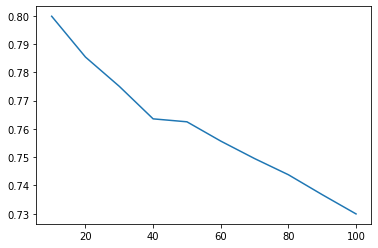

In [270]:
fig = plt.figure()
plt.plot(neighbours_list, score_list)
plt.show()

In [271]:
print(score_list)

[0.7998513798661945, 0.7854070887549143, 0.7750549023096922, 0.7635559406122057, 0.7625125532549583, 0.7556907789448846, 0.7495102776027928, 0.7437866916356168, 0.7367442165124765, 0.7299309807688552]


## GradientBoostingRegressor

In [272]:
model = GradientBoostingRegressor(random_state=1)
model = model.fit(X_train, np.ravel(y_train))

In [273]:
predictions = get_predictions(model)
explained_variance_score(actual_values, predictions)

0.9055530562396438

In [275]:
estimators = []
score_list = []
for i in range(100, 1700, 100):
  estimators.append(i)
  model = GradientBoostingRegressor(random_state=1, n_estimators=i)
  model = model.fit(X_train, np.ravel(y_train))
  predictions = get_predictions(model)
  score = explained_variance_score(actual_values, predictions)
  score_list.append(score)

In [276]:
print(len(estimators))
print(len(score_list))

16
16


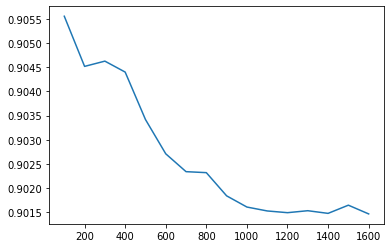

In [277]:
fig = plt.figure()
plt.plot(estimators, score_list)
plt.show()

In [278]:
print(score_list)

[0.9055530562396438, 0.9045173698806478, 0.9046259443602638, 0.9043999503061189, 0.9034203548937091, 0.9027120182926339, 0.9023432206108328, 0.902322733424829, 0.9018438373021275, 0.9016124798016354, 0.901531833941699, 0.9014960760910573, 0.901536695278341, 0.9014817416035883, 0.9016509462374476, 0.9014705006640396]


In [279]:
# Different learning rate...

estimators = []
score_list = []
for i in range(100, 1700, 100):
  estimators.append(i)
  model = GradientBoostingRegressor(random_state=1, learning_rate=0.2, n_estimators=i)
  model = model.fit(X_train, np.ravel(y_train))
  predictions = get_predictions(model)
  score = explained_variance_score(actual_values, predictions)
  score_list.append(score)

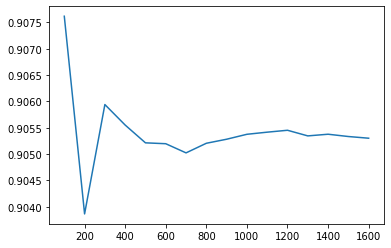

In [280]:
fig = plt.figure()
plt.plot(estimators, score_list)
plt.show()

In [281]:
print(score_list)

[0.9076165878156034, 0.9038642260028962, 0.9059401680590644, 0.9055510800415125, 0.9052134713055673, 0.9051968753977083, 0.905023023700907, 0.90520524874849, 0.9052819043030335, 0.9053757848497228, 0.9054160565636209, 0.9054521420190719, 0.9053453143530007, 0.9053769270902531, 0.9053334154780939, 0.9053012124279972]


## RandomForestRegressor

In [282]:
estimators = []
score_list = []
for i in range(100, 1500, 100):
  estimators.append(i)
  model = RandomForestRegressor(n_estimators=i, max_features=None, max_depth=2, random_state=0)
  model = model.fit(X_train, np.ravel(y_train))
  predictions = get_predictions(model)
  score = explained_variance_score(actual_values, predictions)
  score_list.append(score)

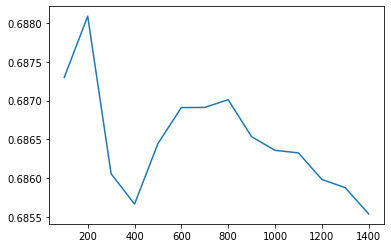

In [283]:
fig = plt.figure()
plt.plot(estimators, score_list)
plt.show()

In [284]:
print(score_list)

[0.6873019124761943, 0.6880913984437207, 0.6860551191327628, 0.6856623377743909, 0.6864452287437103, 0.6869104941167399, 0.686912060688806, 0.6870124124998453, 0.6865338647700936, 0.6863577254469875, 0.6863248262777787, 0.6859817261278868, 0.6858744397286825, 0.6855355184614875]


## ElasticNet

In [285]:
model = ElasticNet(random_state=0)
model.fit(X_train, y_train)

ElasticNet(random_state=0)

In [286]:
predictions = get_predictions(model)

In [287]:
score = explained_variance_score(actual_values, predictions)

In [288]:
print(score)

0.6903762574965657


## kernelRidge

In [289]:
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)

KernelRidge(alpha=1.0)

In [290]:
predictions = get_predictions(krr)

In [291]:
score = explained_variance_score(actual_values, predictions)
print(score)

0.3929398790097939


## Ensemble

In [293]:
reg1 = GradientBoostingRegressor(random_state=1, learning_rate=0.2, n_estimators=100)
reg2 = RandomForestRegressor(n_estimators=200, max_features=None, max_depth=2, random_state=0)
reg3 = KNeighborsRegressor(n_neighbors=10)
reg4 = ElasticNet(random_state=0)
reg5 = KernelRidge(alpha=1.0)

ereg = VotingRegressor(estimators=[("gb", reg1), ("rf", reg2), ("knn", reg3), ("en", reg4)])
ereg = ereg.fit(X_train, np.ravel(y_train))
predictions = get_predictions(ereg)

In [294]:
print(len(predictions))
print(len(actual_values))

292
292


In [295]:
score = explained_variance_score(actual_values, predictions)

In [296]:
print(score)

0.8293680326375961


In [297]:
reg1 = GradientBoostingRegressor(random_state=1, learning_rate=0.2, n_estimators=100)
reg3 = KNeighborsRegressor(n_neighbors=10)
ereg = VotingRegressor(estimators=[("gb", reg1), ("knn", reg3)])
ereg = ereg.fit(X_train, np.ravel(y_train))
predictions = get_predictions(ereg)
explained_variance_score(actual_values, predictions)


0.879888974191469

## Actual model used for predicting house prices

In [298]:
reg1 = GradientBoostingRegressor(random_state=1, learning_rate=0.2, n_estimators=100)

In [299]:
reg1 = reg1.fit(train_after_split, np.ravel(train_data_y))

In [ ]:
reg1 = GradientBoostingRegressor(random_state=1, learning_rate=0.2, n_estimators=1600)
reg2 = RandomForestRegressor(n_estimators=300, max_features=None, max_depth=2, random_state=0)
reg3 = KNeighborsRegressor(n_neighbors=40)
reg4 = ElasticNet(random_state=0)
reg5 = KernelRidge(alpha=1.0)
ereg = VotingRegressor(estimators=[("gb", reg1), ("rf", reg2), ("knn", reg3), ("en", reg4), ("kr", reg5)])
ereg = ereg.fit(train_after_split, np.ravel(train_data_y))

In [ ]:
reg2 = RandomForestRegressor(n_estimators=1000, max_features=None, max_depth=2, random_state=0)

In [ ]:
reg2 = reg2.fit(train_after_split, np.ravel(train_data_y))
y_predict = reg2.predict(test_after_split.iloc[[26]])
print(y_predict)

[288139.54384915]


In [ ]:
reg3 = LinearRegression()

In [ ]:
reg4 = KNeighborsRegressor(n_neighbors=7)

In [ ]:
ereg = VotingRegressor(estimators=[("gb", reg1), ("rf", reg2), ("lr", reg3), ("knn", reg4)])

In [ ]:
ereg = ereg.fit(train_after_split, np.ravel(train_data_y))

In [300]:
y_predict = reg1.predict(test_after_split.iloc[[26]])
print(y_predict)

[372825.64456178]


In [301]:
predictions = []

for idx in range(len(test_after_split)):
  try:
    y_predict = reg1.predict(test_after_split.iloc[[idx]])
  except Exception:
    print(test_after_split.iloc[[idx]])
  y_predict = int(y_predict)
  predictions.append(y_predict)
print(predictions)
print(len(predictions))

[131923, 164150, 179591, 182684, 189666, 171385, 170590, 160369, 172329, 127877, 209578, 95485, 91453, 152327, 129924, 428013, 243970, 304080, 289915, 483044, 324408, 219866, 171374, 173631, 180596, 194704, 372825, 238171, 198356, 227626, 189721, 91035, 185791, 297876, 308454, 218130, 170718, 168340, 162812, 147188, 160663, 157193, 304427, 231453, 219532, 190130, 238017, 205000, 166798, 142669, 147095, 169036, 144169, 186024, 193544, 166093, 164613, 130745, 229496, 134105, 137090, 161462, 108113, 127585, 126585, 125491, 99543, 143326, 143862, 173790, 119188, 107740, 145014, 124449, 169271, 113109, 75301, 201006, 218518, 99872, 145887, 132771, 214316, 87235, 109146, 126410, 136223, 139571, 119973, 133851, 116247, 124132, 171701, 113912, 177942, 84948, 106515, 90808, 75385, 122209, 138434, 126625, 119392, 147515, 150016, 239728, 74067, 211680, 127423, 143910, 123708, 158138, 284942, 109478, 205930, 233666, 207077, 145550, 151394, 194190, 162691, 121550, 349639, 231950, 141629, 78404, 942

In [302]:
ids = df_test["Id"].tolist()
print(ids)
print(len(ids))

[1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 162

In [303]:
dictionary_of_lists = {"Id": ids, "SalePrice": predictions}
final_dataframe = pd.DataFrame(dictionary_of_lists)
final_dataframe.head()

,Id,SalePrice
0,1461,131923
1,1462,164150
2,1463,179591
3,1464,182684
4,1465,189666


In [304]:
final_dataframe.to_csv("my_predictions.csv", index=False)